Phần 1. Tiền xử lý dữ liệu

In [1]:
# ==========================
# 1. Import thư viện cần thiết
# ==========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns  

# ==========================
# 2. Đọc dữ liệu
# ==========================
file_path = "social_media_vs_productivity.csv"
df = pd.read_csv(file_path)

In [2]:
# ==========================
# 3. Xử lý giá trị thiếu
# ==========================
df.fillna(df.median(numeric_only=True), inplace=True)

for col in df.select_dtypes(include=["object"]).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# ==========================
# 4. Mã hóa biến phân loại
# ==========================
label_cols = ['gender', 'job_type', 'social_platform_preference']
encoders = {}

for col in label_cols:
    if col in df.columns:
        encoders[col] = LabelEncoder()
        df[col] = encoders[col].fit_transform(df[col])

# ==========================
# 5. Chuyển dữ liệu Boolean thành số
# ==========================
bool_cols = ['uses_focus_apps', 'has_digital_wellbeing_enabled']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)

# ==========================
# 6. Hàm xử lý ngoại lệ bằng IQR
# ==========================
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data[column] = np.clip(data[column], lower, upper)
    return data

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
exclude_cols = ['stress_level', 'breaks_during_work', 'coffee_consumption_per_day']
for col in numeric_cols:
    if col not in exclude_cols:
        df = remove_outliers_iqr(df, col)

# ==========================
# 7. Tạo biến nhãn nhị phân từ actual_productivity_score
# ==========================
if 'actual_productivity_score' in df.columns:
    df['imbalance_label'] = np.where(
        df['actual_productivity_score'] <= 5,
        'Yes (<=5)',     # mất cân bằng (năng suất thấp)
        'No (>5)'   # không mất cân bằng
    )
else:
    raise KeyError("Không tìm thấy cột 'actual_productivity_score' trong dữ liệu!")

# ==========================
# 8. Kiểm tra kết quả
# ==========================
print("Kích thước dữ liệu sau xử lý:", df.shape)
print("\nPhân phối nhãn (Có/Không mất cân bằng):")
print(df['imbalance_label'].value_counts())

Kích thước dữ liệu sau xử lý: (30000, 20)

Phân phối nhãn (Có/Không mất cân bằng):
Yes (<=5)    16377
No (>5)      13623
Name: imbalance_label, dtype: int64


In [3]:
# ==========================
# 9. CHIA DỮ LIỆU THÀNH TRAIN / TEST CHO ID3 & CART
# ==========================

# Xác định đặc trưng (X) và nhãn mục tiêu (y)
X = df.drop(columns=['actual_productivity_score', 'imbalance_label'])
y = df['imbalance_label']

# Chia tập huấn luyện và kiểm tra (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # đảm bảo tỷ lệ Low/Medium/High đồng đều
)

# ==========================
# 10. Kiểm tra kết quả chia dữ liệu
# ==========================
print("\nKích thước tập huấn luyện (Train):", X_train.shape)
print("Kích thước tập kiểm tra (Test):", X_test.shape)

print("\nPhân phối nhãn trong tập huấn luyện:")
print(y_train.value_counts(normalize=True))

print("\nPhân phối nhãn trong tập kiểm tra:")
print(y_test.value_counts(normalize=True))


Kích thước tập huấn luyện (Train): (24000, 18)
Kích thước tập kiểm tra (Test): (6000, 18)

Phân phối nhãn trong tập huấn luyện:
Có (<=5)      0.545917
Không (>5)    0.454083
Name: imbalance_label, dtype: float64

Phân phối nhãn trong tập kiểm tra:
Có (<=5)      0.545833
Không (>5)    0.454167
Name: imbalance_label, dtype: float64


Phần 2. Xây dựng mô hình

In [4]:
# ==========================
# 1 . Import thư viện & Chuẩn bị dữ liệu
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [5]:
# ==========================
# 2 . Hàm đánh giá mô hình (Evaluation)
# ==========================
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X_train, y_train, X_test, y_test, name, results):
    """
    Hàm đánh giá mô hình:
    - Tính Accuracy, F1, Recall, Precision
    - Vẽ Confusion Matrix (màu xanh lam)
    - In Classification Report
    - Lưu kết quả vào list 'results'
    """
    # ------------------------
    # Dự đoán & tính chỉ số
    # ------------------------
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    pre = precision_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # ------------------------
    # In kết quả ra console
    # ------------------------
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Recall: {rec:.4f} | Precision: {pre:.4f}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # ------------------------
    # Vẽ Confusion Matrix (giống hình minh họa)
    # ------------------------
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,               # hiển thị số liệu trong ô
        fmt="d",                  # định dạng là số nguyên
        cmap="Blues",             # thang màu xanh lam
        cbar=True,                # hiển thị thanh màu bên phải
        linewidths=0.5            # thêm viền mảnh giữa các ô
    )
    plt.title(f"Confusion Matrix - {name}", fontsize=14)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.tight_layout()
    plt.show()

    # ------------------------
    # Lưu kết quả vào danh sách results
    # ------------------------
    results.append({
        'model': name,
        'accuracy': acc,
        'f1': f1,
        'recall': rec,
        'precision': pre,
        'depth': model.get_depth() if hasattr(model, 'get_depth') else np.nan,
        'nodes': model.get_n_leaves() if hasattr(model, 'get_n_leaves') else np.nan
    })

    return y_pred


Max_depth tối ưu cho ID3 = 5, CV Accuracy trung bình = 0.9010

=== ID3 (Entropy, max_depth=5) ===
Accuracy: 0.8973 | F1: 0.8975 | Recall: 0.8973 | Precision: 0.8986
Confusion Matrix:
 [[2897  378]
 [ 238 2487]]

Classification Report:
               precision    recall  f1-score   support

    Có (<=5)       0.92      0.88      0.90      3275
  Không (>5)       0.87      0.91      0.89      2725

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



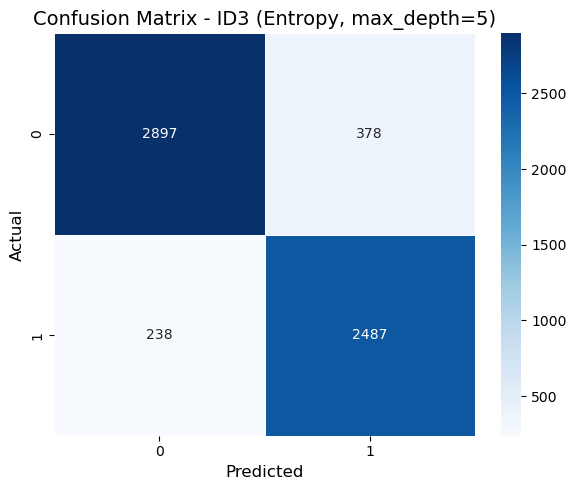

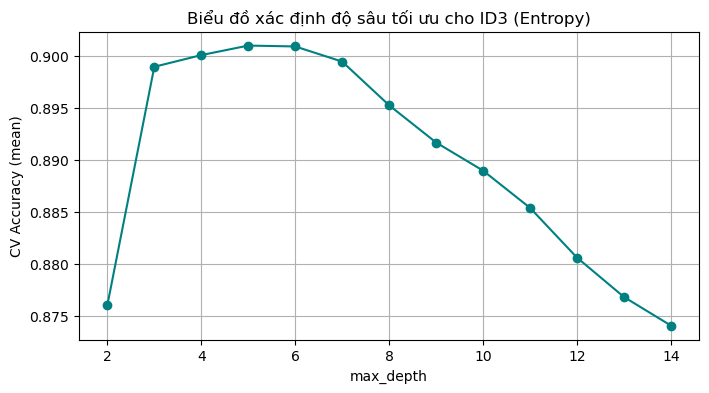

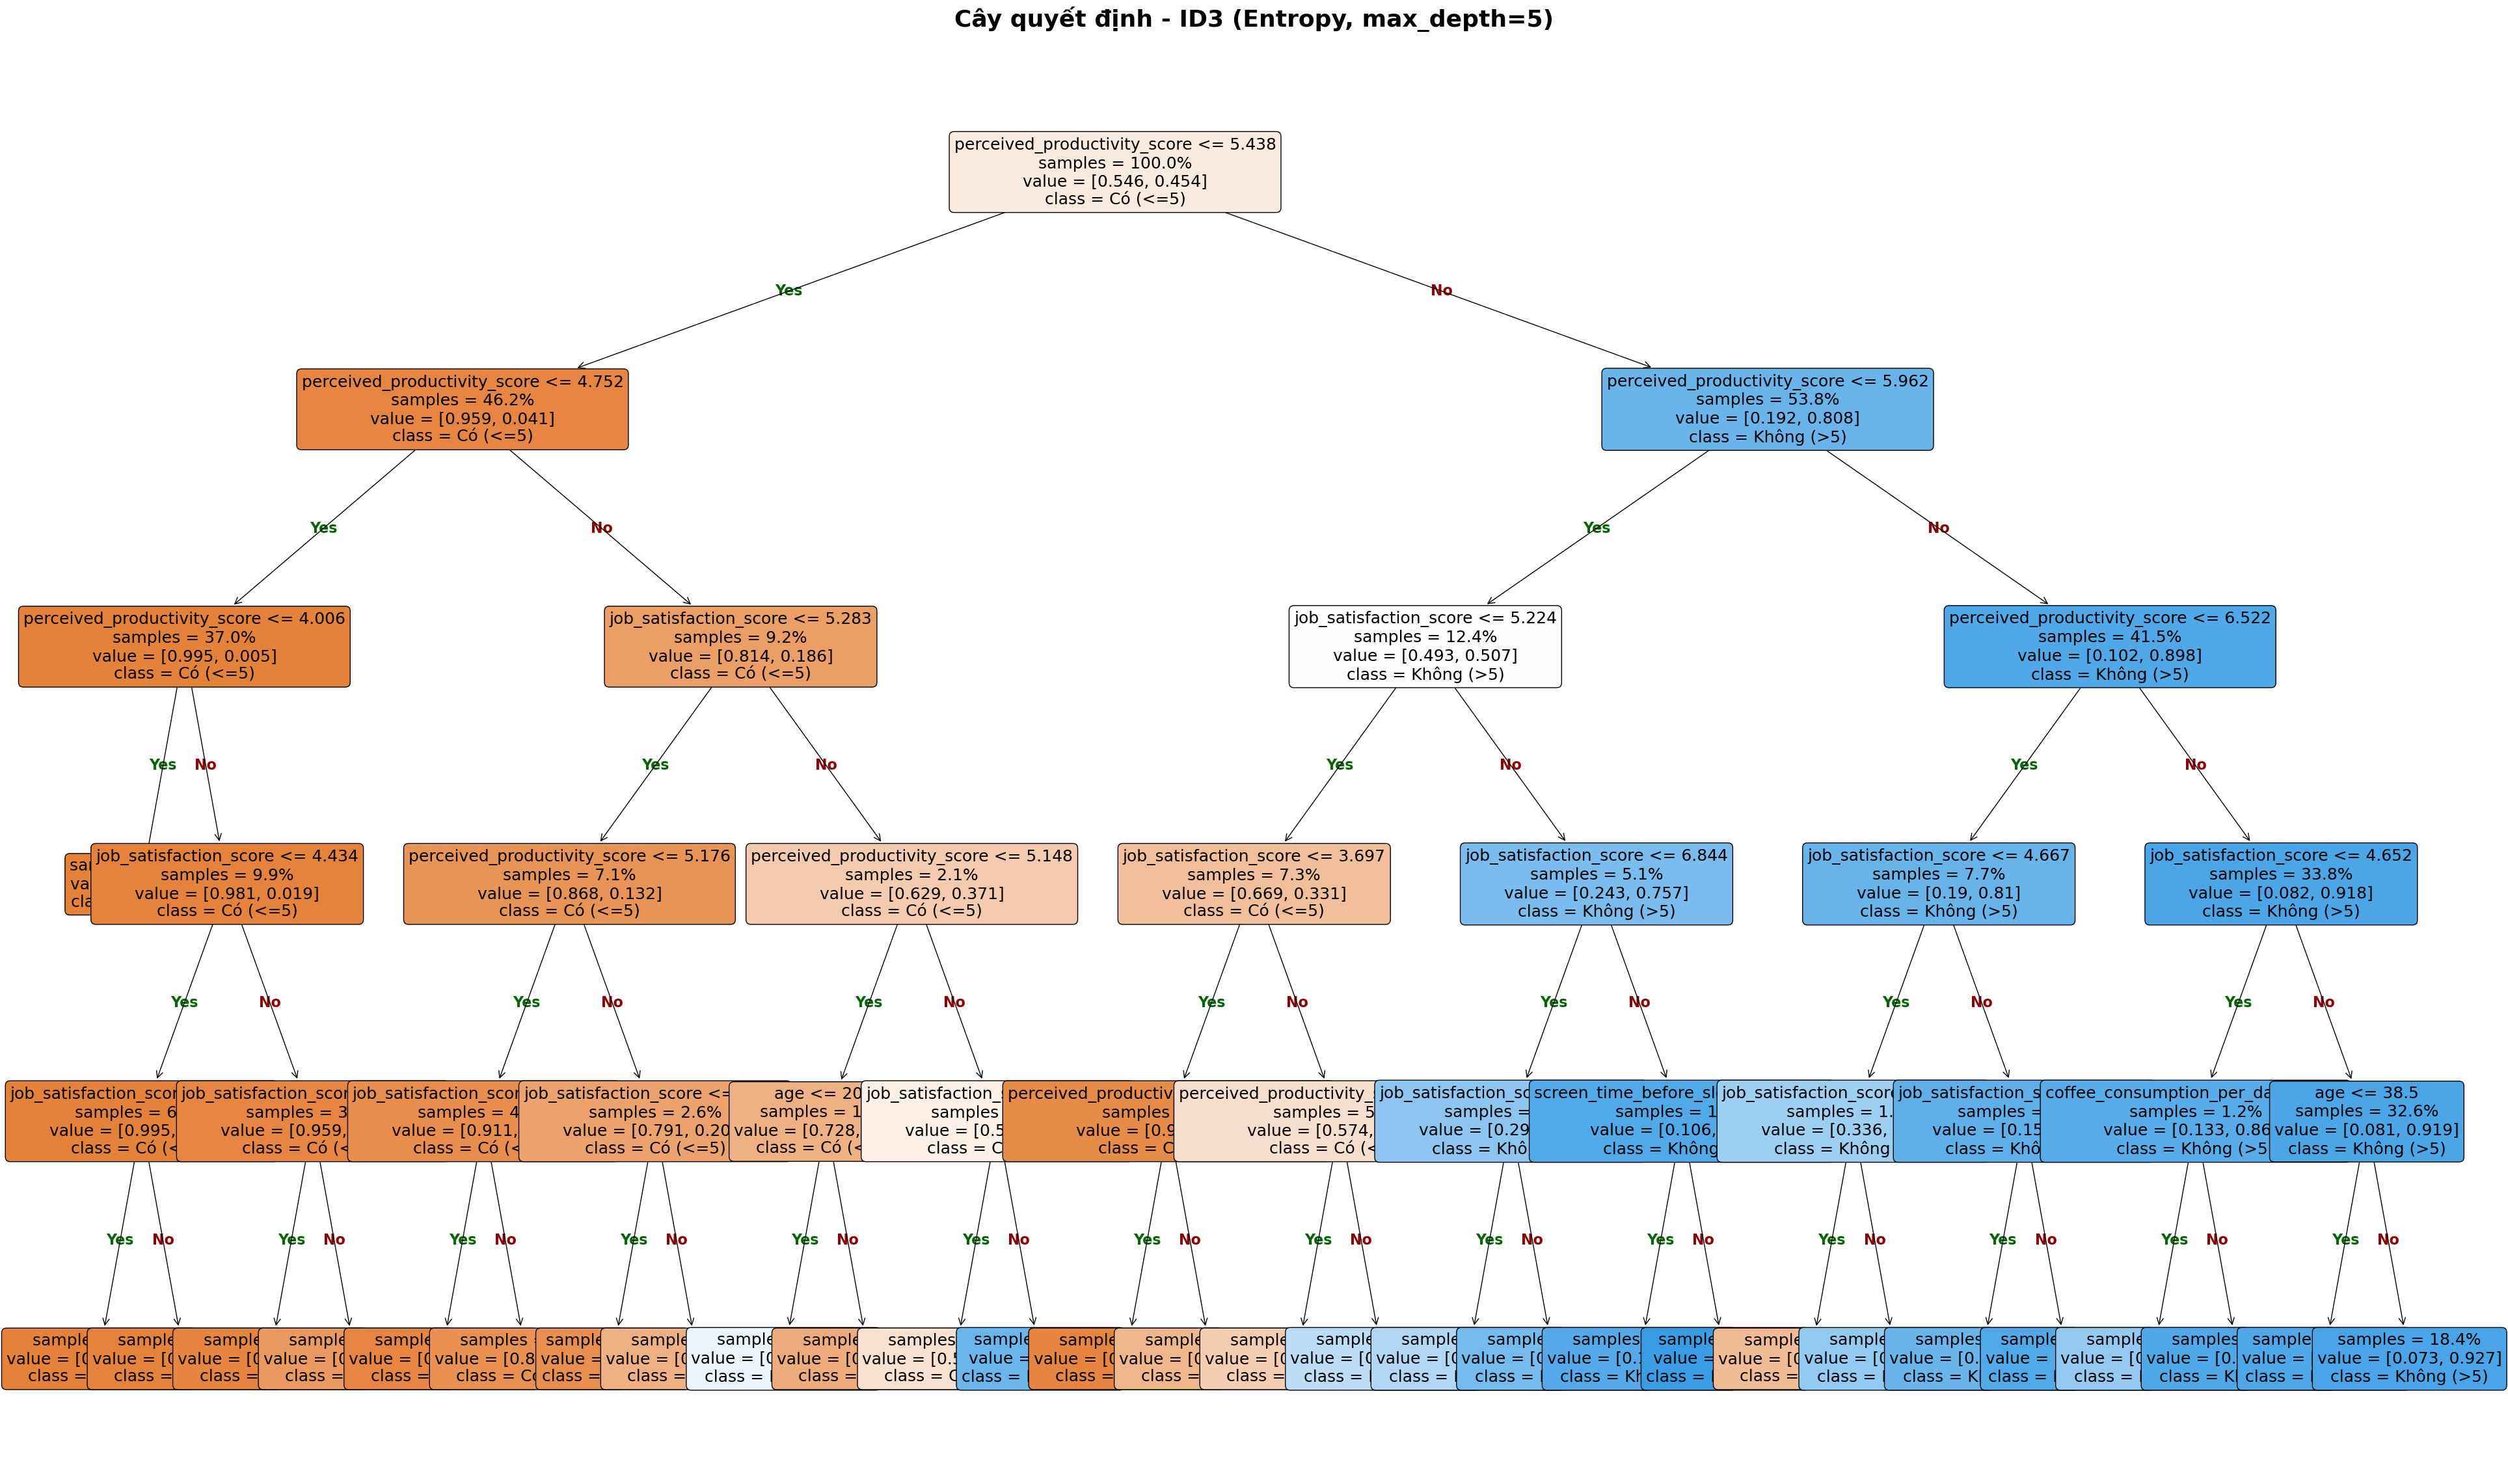

Đã lưu cây quyết định dưới dạng: decision_tree_id3.png và decision_tree_id3.pdf


In [6]:
# ==========================
# 3. Mô hình 1: ID3 (Entropy / Information Gain) – CÓ TỰ CHỌN max_depth
# ==========================
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# ------------------------------------
# Tìm max_depth tối ưu bằng cross-validation
# ------------------------------------
depths = range(2, 15)
cv_scores = []

for d in depths:
    model = DecisionTreeClassifier(criterion="entropy", max_depth=d, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_scores.append(scores.mean())

# Chọn max_depth có accuracy trung bình cao nhất
best_depth = depths[np.argmax(cv_scores)]
best_score = max(cv_scores)

print(f"Max_depth tối ưu cho ID3 = {best_depth}, CV Accuracy trung bình = {best_score:.4f}")

# ------------------------------------
# Huấn luyện mô hình ID3 với max_depth tối ưu
# ------------------------------------
dt_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=best_depth, random_state=42)
dt_entropy.fit(X_train, y_train)

results = []
_ = evaluate_model(dt_entropy, X_train, y_train, X_test, y_test, f"ID3 (Entropy, max_depth={best_depth})", results)

# ------------------------------------
# Biểu đồ thể hiện sự thay đổi accuracy theo max_depth
# ------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(depths, cv_scores, marker='o', color='teal')
plt.title("Biểu đồ xác định độ sâu tối ưu cho ID3 (Entropy)")
plt.xlabel("max_depth")
plt.ylabel("CV Accuracy (mean)")
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# ------------------------------------
# Vẽ cây quyết định (phóng to + có nhánh Yes/No)
# ------------------------------------
fig, ax = plt.subplots(figsize=(40, 24))  

tree_nodes = plot_tree(
    dt_entropy,
    filled=True,
    rounded=True,
    feature_names=X_train.columns,
    class_names=[str(c) for c in dt_entropy.classes_],
    fontsize=18,           
    proportion=True,
    impurity=False,
    ax=ax
)

plt.title(f"Cây quyết định - ID3 (Entropy, max_depth={best_depth})", fontsize=26, fontweight='bold', pad=30)

# ------------------------------------
# Thêm chữ "Yes"/"No" cho các nhánh
# ------------------------------------
tree_ = dt_entropy.tree_

# Mỗi node có thể có node con trái/phải, ta ghi nhãn vào giữa đường nối
for i in range(tree_.node_count):
    if tree_.children_left[i] != -1:  # chỉ xét node không phải là lá
        left = tree_.children_left[i]
        right = tree_.children_right[i]
        
        # Lấy vị trí node cha & node con
        x0, y0 = tree_nodes[i].get_position()
        xL, yL = tree_nodes[left].get_position()
        xR, yR = tree_nodes[right].get_position()

        # Thêm chữ "Yes" ở giữa đường trái
        plt.text((x0 + xL) / 2, (y0 + yL) / 2, "Yes",
                 fontsize=16, color='darkgreen', ha='center', va='center', fontweight='bold')
        # Thêm chữ "No" ở giữa đường phải
        plt.text((x0 + xR) / 2, (y0 + yR) / 2, "No",
                 fontsize=16, color='darkred', ha='center', va='center', fontweight='bold')

plt.tight_layout(pad=5.0)

# ------------------------------------
# Xuất file hình ảnh / PDF chất lượng cao
# ------------------------------------
plt.savefig("decision_tree_id3.png", dpi=300, bbox_inches='tight')   # Ảnh PNG sắc nét
plt.savefig("decision_tree_id3.pdf", bbox_inches='tight')            # PDF có thể phóng to vô hạn

plt.show()

print("Đã lưu cây quyết định dưới dạng: decision_tree_id3.png và decision_tree_id3.pdf")

Max_depth tối ưu cho ID3 = 5, CV Accuracy trung bình = 0.9010

=== ID3 (Entropy, max_depth=5) ===
Accuracy: 0.8973 | F1: 0.8975 | Recall: 0.8973 | Precision: 0.8986
Confusion Matrix:
 [[2897  378]
 [ 238 2487]]

Classification Report:
               precision    recall  f1-score   support

    Có (<=5)       0.92      0.88      0.90      3275
  Không (>5)       0.87      0.91      0.89      2725

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



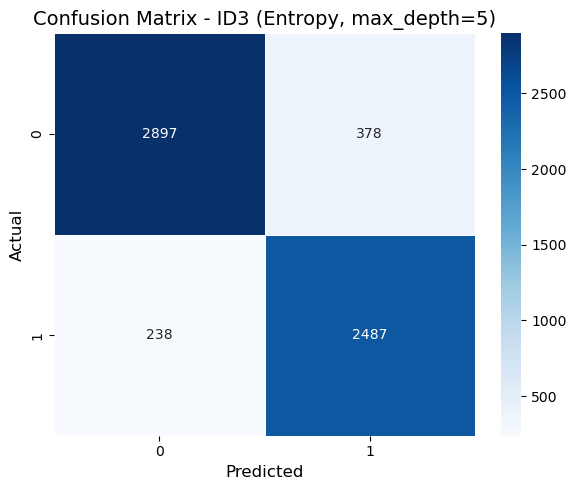

Best ccp_alpha: 0.00050, Accuracy: 0.8968

=== ID3 Post-Pruned (ccp_alpha=0.00050) ===
Accuracy: 0.8968 | F1: 0.8970 | Recall: 0.8968 | Precision: 0.8981
Confusion Matrix:
 [[2897  378]
 [ 241 2484]]

Classification Report:
               precision    recall  f1-score   support

    Có (<=5)       0.92      0.88      0.90      3275
  Không (>5)       0.87      0.91      0.89      2725

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



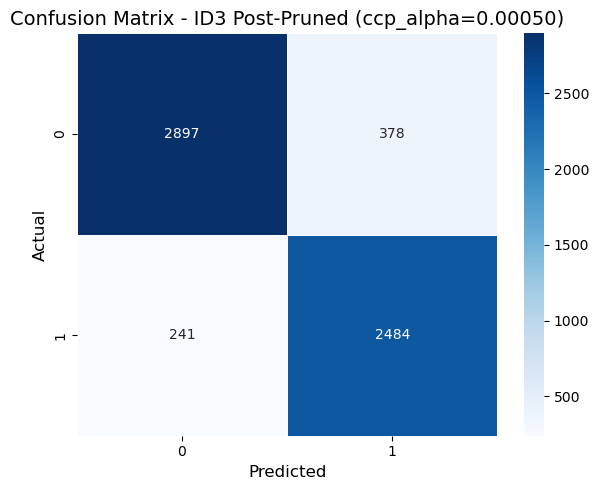

In [7]:
# ==========================
# 3.1. Mô hình 1: ID3 (Entropy / Information Gain) – CÓ TỰ CHỌN max_depth + Post-Pruning
# ==========================
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# ------------------------------------
# Tìm max_depth tối ưu bằng cross-validation
# ------------------------------------
depths = range(2, 15)
cv_scores = []

for d in depths:
    model = DecisionTreeClassifier(criterion="entropy", max_depth=d, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_scores.append(scores.mean())

# Chọn max_depth có accuracy trung bình cao nhất
best_depth = depths[np.argmax(cv_scores)]
best_score = max(cv_scores)

print(f"Max_depth tối ưu cho ID3 = {best_depth}, CV Accuracy trung bình = {best_score:.4f}")

# ------------------------------------
# Huấn luyện mô hình ID3 với max_depth tối ưu
# ------------------------------------
dt_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=best_depth, random_state=42)
dt_entropy.fit(X_train, y_train)

results = []
_ = evaluate_model(dt_entropy, X_train, y_train, X_test, y_test, f"ID3 (Entropy, max_depth={best_depth})", results)

# ====================================================
#  Post-Pruning: Cost Complexity Pruning (CCP)
# ====================================================
path = dt_entropy.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

models = []
scores = []

for ccp in ccp_alphas:
    model = DecisionTreeClassifier(criterion="entropy", random_state=42, ccp_alpha=ccp)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
    models.append(model)

best_ccp = ccp_alphas[np.argmax(scores)]
best_model = models[np.argmax(scores)]

print(f"Best ccp_alpha: {best_ccp:.5f}, Accuracy: {max(scores):.4f}")

# ------------------------------------
# Đánh giá mô hình sau khi cắt tỉa
# ------------------------------------
_ = evaluate_model(best_model, X_train, y_train, X_test, y_test, f"ID3 Post-Pruned (ccp_alpha={best_ccp:.5f})", results)


Max_depth tối ưu cho CART = 5, CV Accuracy trung bình = 0.9021

=== CART (Gini, max_depth=5) ===
Accuracy: 0.8952 | F1: 0.8954 | Recall: 0.8952 | Precision: 0.8975
Confusion Matrix:
 [[2863  412]
 [ 217 2508]]

Classification Report:
               precision    recall  f1-score   support

    Có (<=5)       0.93      0.87      0.90      3275
  Không (>5)       0.86      0.92      0.89      2725

    accuracy                           0.90      6000
   macro avg       0.89      0.90      0.89      6000
weighted avg       0.90      0.90      0.90      6000



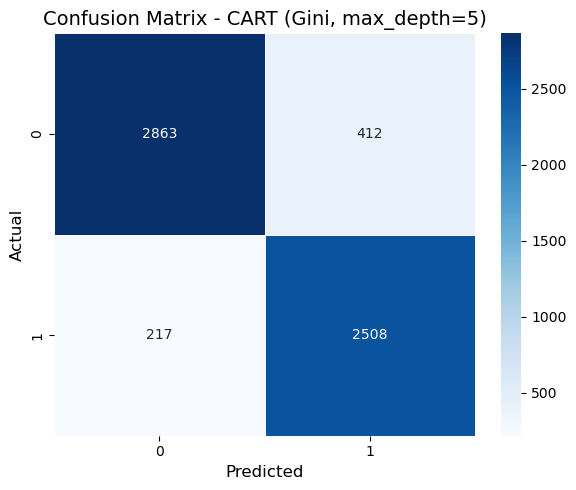

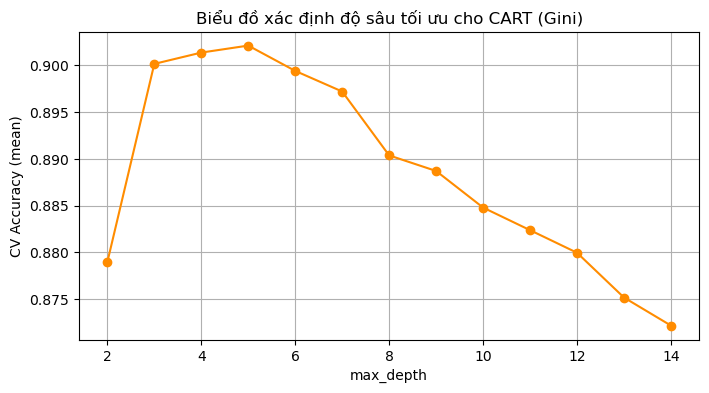

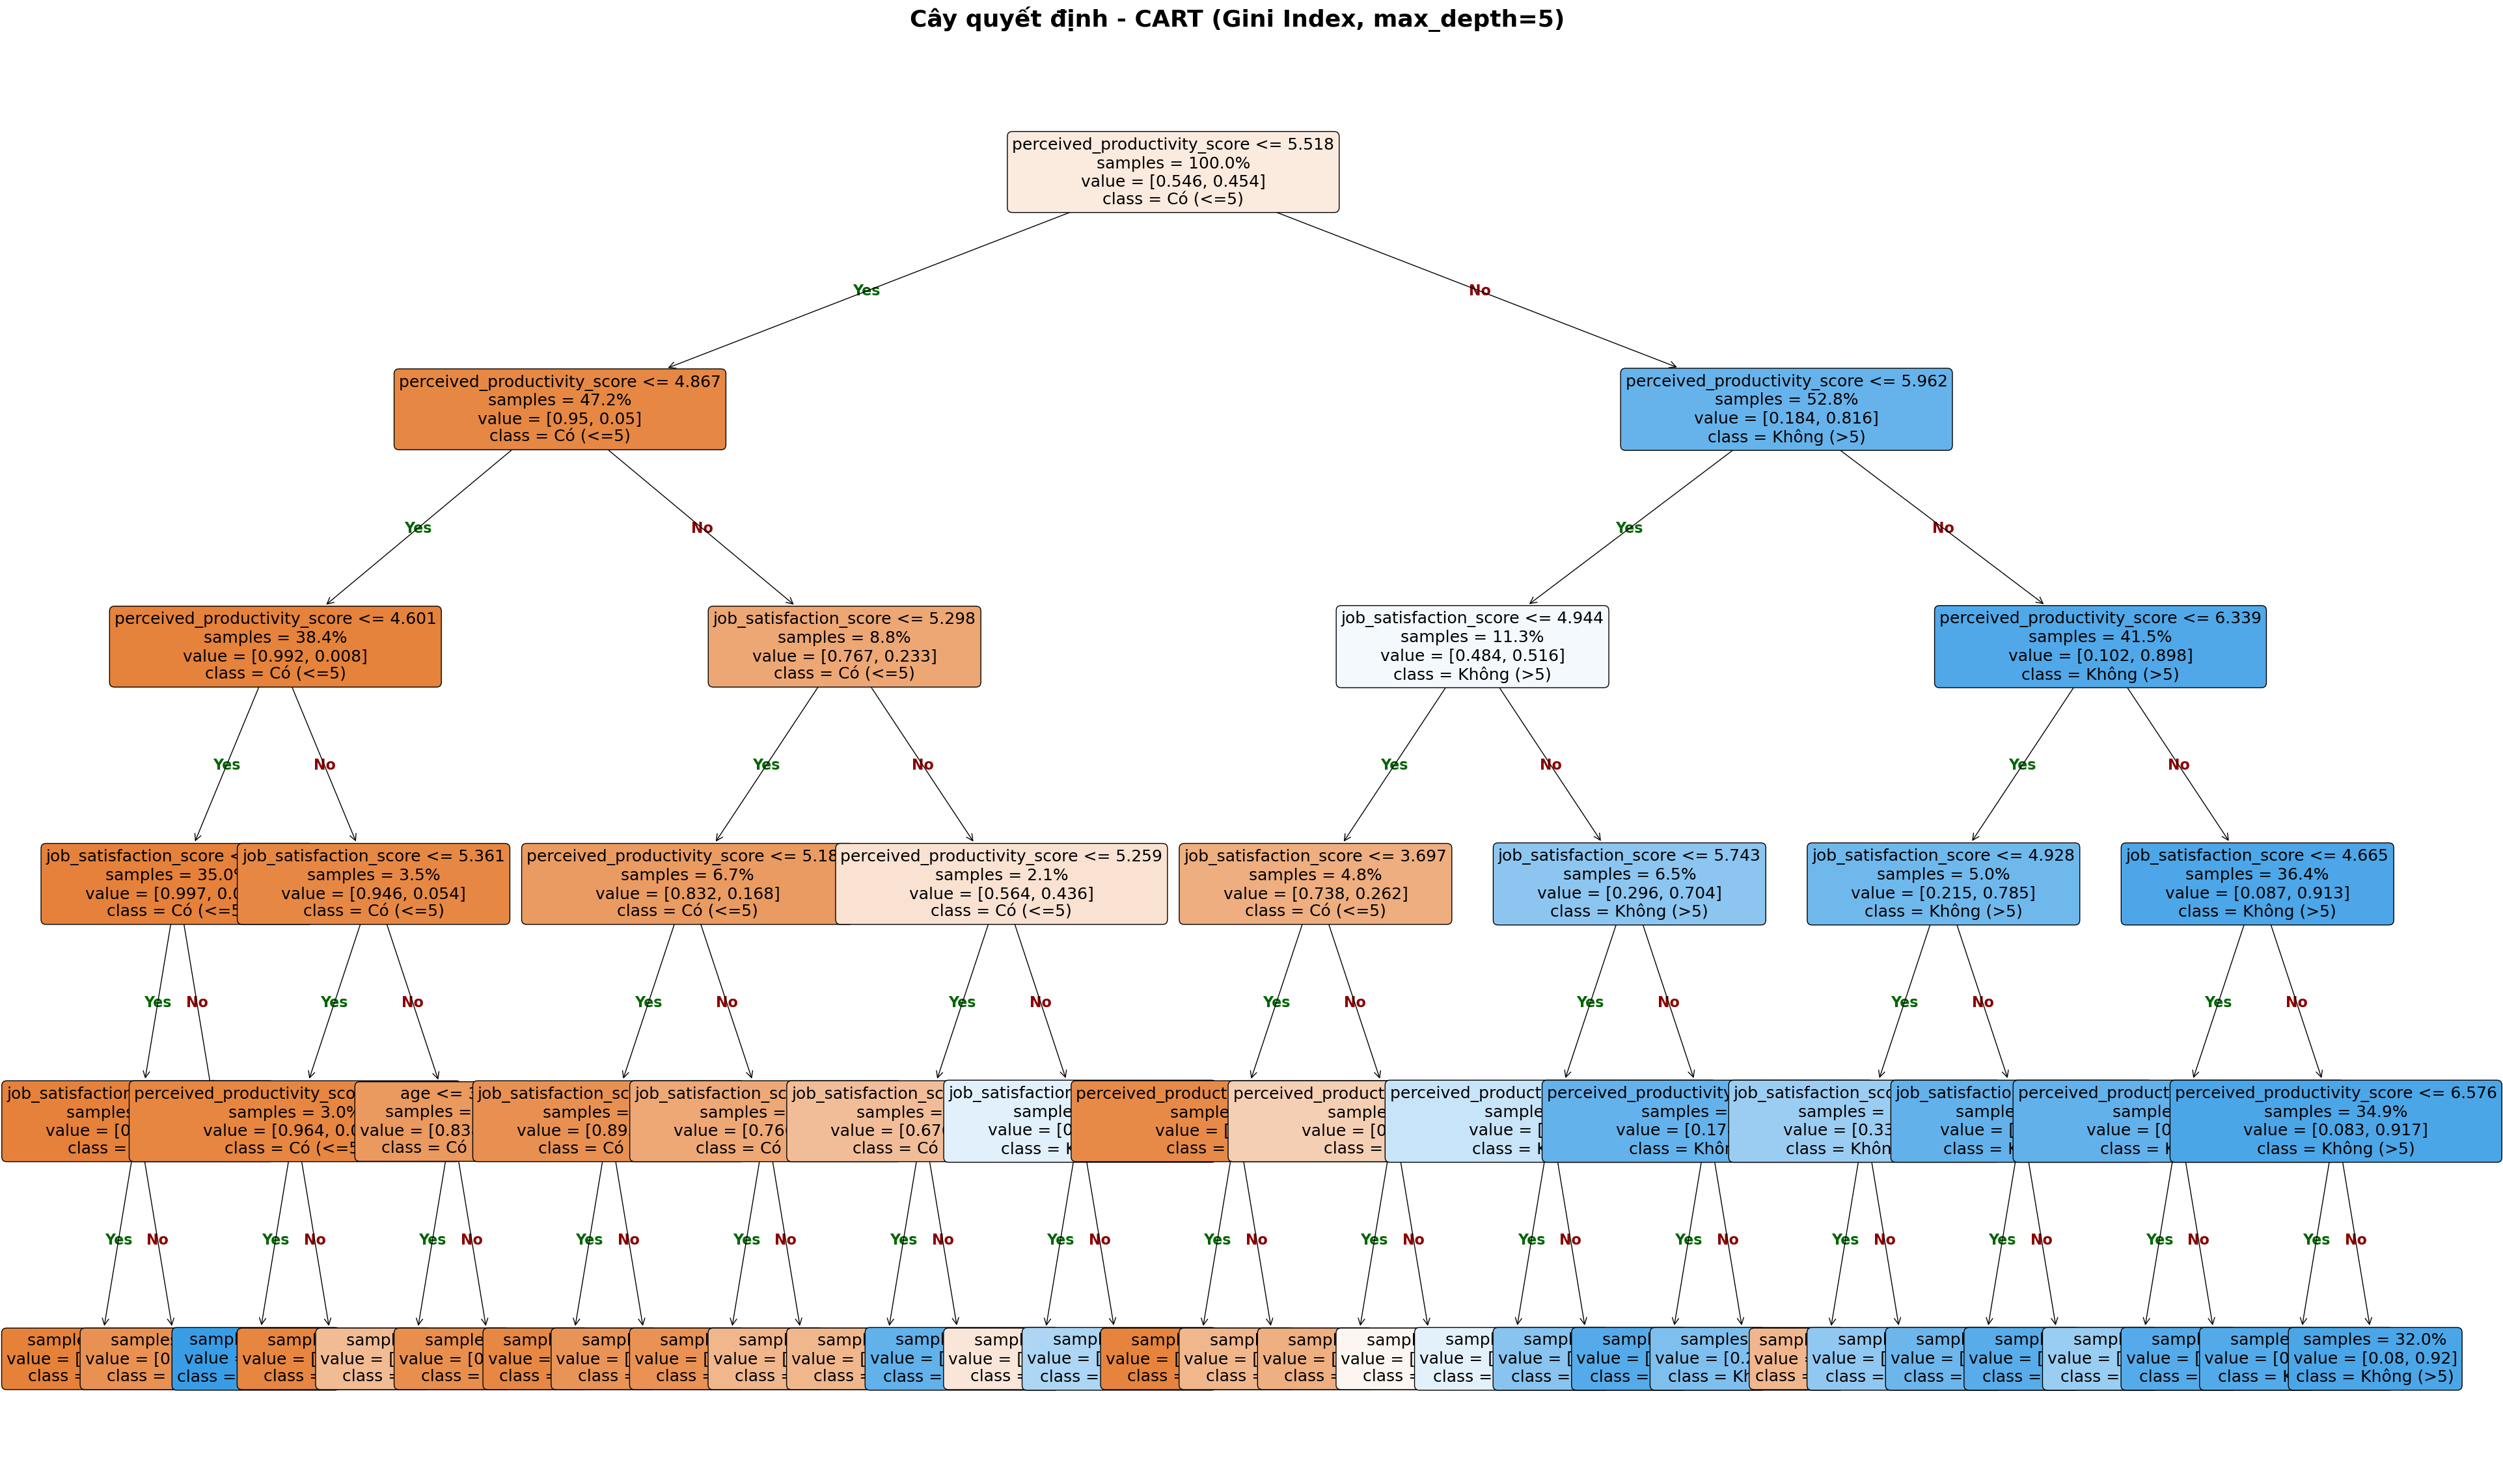

Đã lưu: CART_Gini_Tree.png và CART_Gini_Tree.pdf



In [8]:
# ==========================
# 4. Mô hình 2: CART (Gini Index) – CÓ TỰ CHỌN max_depth
# ==========================
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# ------------------------------------
# Tìm max_depth tối ưu bằng cross-validation
# ------------------------------------
depths = range(2, 15)
cv_scores = []

for d in depths:
    model = DecisionTreeClassifier(criterion="gini", max_depth=d, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_scores.append(scores.mean())

# Chọn max_depth có accuracy trung bình cao nhất
best_depth_gini = depths[np.argmax(cv_scores)]
best_score_gini = max(cv_scores)

print(f"Max_depth tối ưu cho CART = {best_depth_gini}, CV Accuracy trung bình = {best_score_gini:.4f}")

# ------------------------------------
# Huấn luyện mô hình CART với max_depth tối ưu
# ------------------------------------
dt_gini = DecisionTreeClassifier(criterion="gini", max_depth=best_depth_gini, random_state=42)
dt_gini.fit(X_train, y_train)

_ = evaluate_model(dt_gini, X_train, y_train, X_test, y_test, f"CART (Gini, max_depth={best_depth_gini})", results)

# ------------------------------------
# Biểu đồ thể hiện sự thay đổi accuracy theo max_depth
# ------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(depths, cv_scores, marker='o', color='darkorange')
plt.title("Biểu đồ xác định độ sâu tối ưu cho CART (Gini)")
plt.xlabel("max_depth")
plt.ylabel("CV Accuracy (mean)")
plt.grid(True)
plt.show()

# ===============================================================
# TRỰC QUAN HÓA CÂY QUYẾT ĐỊNH CART (Gini)
# ===============================================================
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

def plot_cart_tree(model, X_train, title, filename):
    """Vẽ cây CART phóng to, thêm nhánh Yes/No, lưu PNG và PDF"""
    fig, ax = plt.subplots(figsize=(40, 24))  # 📏 Phóng to toàn bộ cây

    # Vẽ cây với kiểu trình bày đẹp
    nodes = plot_tree(
        model,
        filled=True,
        rounded=True,
        feature_names=X_train.columns,
        class_names=[str(c) for c in model.classes_],
        fontsize=18,
        proportion=True,
        impurity=False,
        ax=ax
    )

    plt.title(title, fontsize=26, fontweight='bold', pad=30)

    # --------------------------------------------------
    # Thêm chữ "Yes" / "No" lên nhánh trái và phải
    # --------------------------------------------------
    tree_ = model.tree_
    for i in range(tree_.node_count):
        if tree_.children_left[i] != -1:  # nếu không phải node lá
            left = tree_.children_left[i]
            right = tree_.children_right[i]

            # Lấy vị trí node cha và node con
            x0, y0 = nodes[i].get_position()
            xL, yL = nodes[left].get_position()
            xR, yR = nodes[right].get_position()

            # Ghi chữ "Yes" và "No"
            plt.text((x0 + xL) / 2, (y0 + yL) / 2, "Yes",
                     fontsize=16, color='darkgreen', ha='center', va='center', fontweight='bold')
            plt.text((x0 + xR) / 2, (y0 + yR) / 2, "No",
                     fontsize=16, color='darkred', ha='center', va='center', fontweight='bold')

    # --------------------------------------------------
    # Lưu cây ra file PNG và PDF
    # --------------------------------------------------
    plt.tight_layout(pad=5.0)
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{filename}.pdf", bbox_inches='tight')
    plt.show()

    print(f"Đã lưu: {filename}.png và {filename}.pdf\n")


# ===============================================================
# GỌI HÀM VẼ CÂY CART SAU KHI HUẤN LUYỆN
# ===============================================================
plot_cart_tree(
    dt_gini,
    X_train,
    title=f"Cây quyết định - CART (Gini Index, max_depth={best_depth_gini})",
    filename="CART_Gini_Tree"
)


Max_depth tối ưu cho CART = 5, CV Accuracy trung bình = 0.9021

=== Bắt đầu quá trình Post-Pruning cho CART ===
Post-Pruning hoàn tất:
   → Best ccp_alpha: 0.00145
   → Accuracy sau pruning: 0.8932


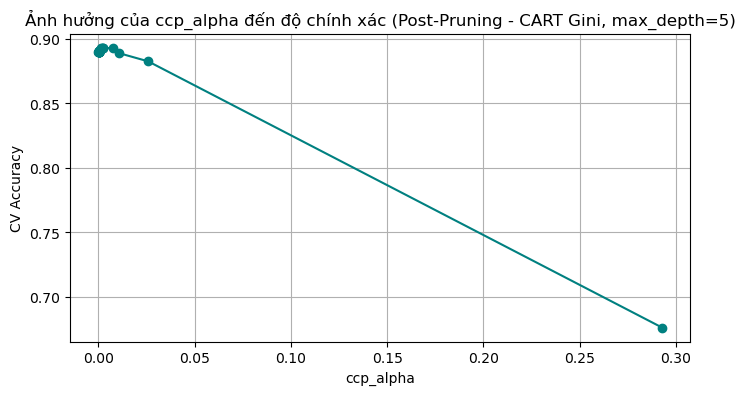


=== CART (Gini, max_depth=5, pruned α=0.00145) ===
Accuracy: 0.8938 | F1: 0.8940 | Recall: 0.8938 | Precision: 0.8954
Confusion Matrix:
 [[2878  397]
 [ 240 2485]]

Classification Report:
               precision    recall  f1-score   support

    Có (<=5)       0.92      0.88      0.90      3275
  Không (>5)       0.86      0.91      0.89      2725

    accuracy                           0.89      6000
   macro avg       0.89      0.90      0.89      6000
weighted avg       0.90      0.89      0.89      6000



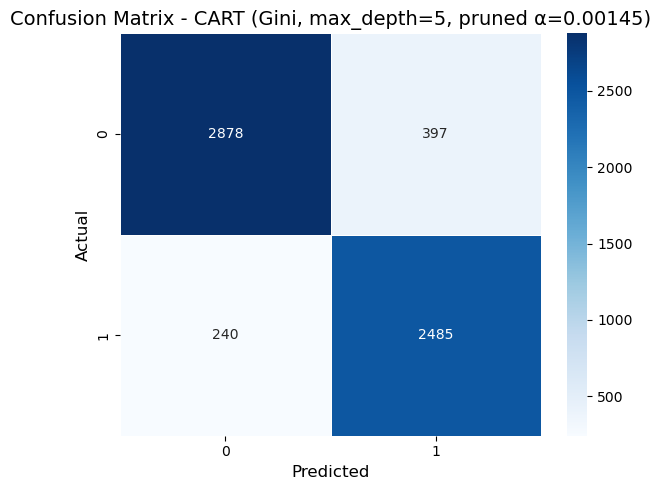

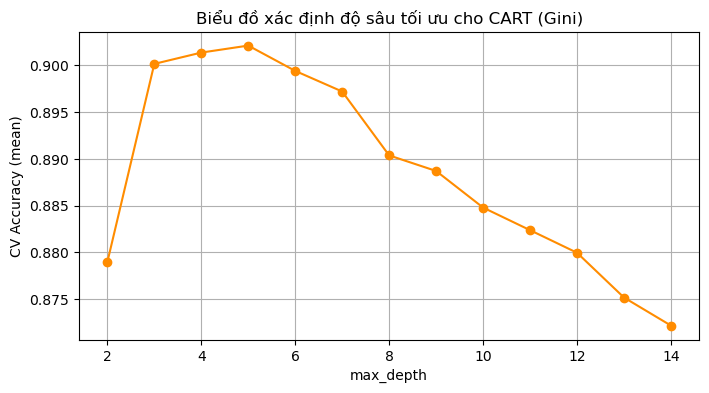

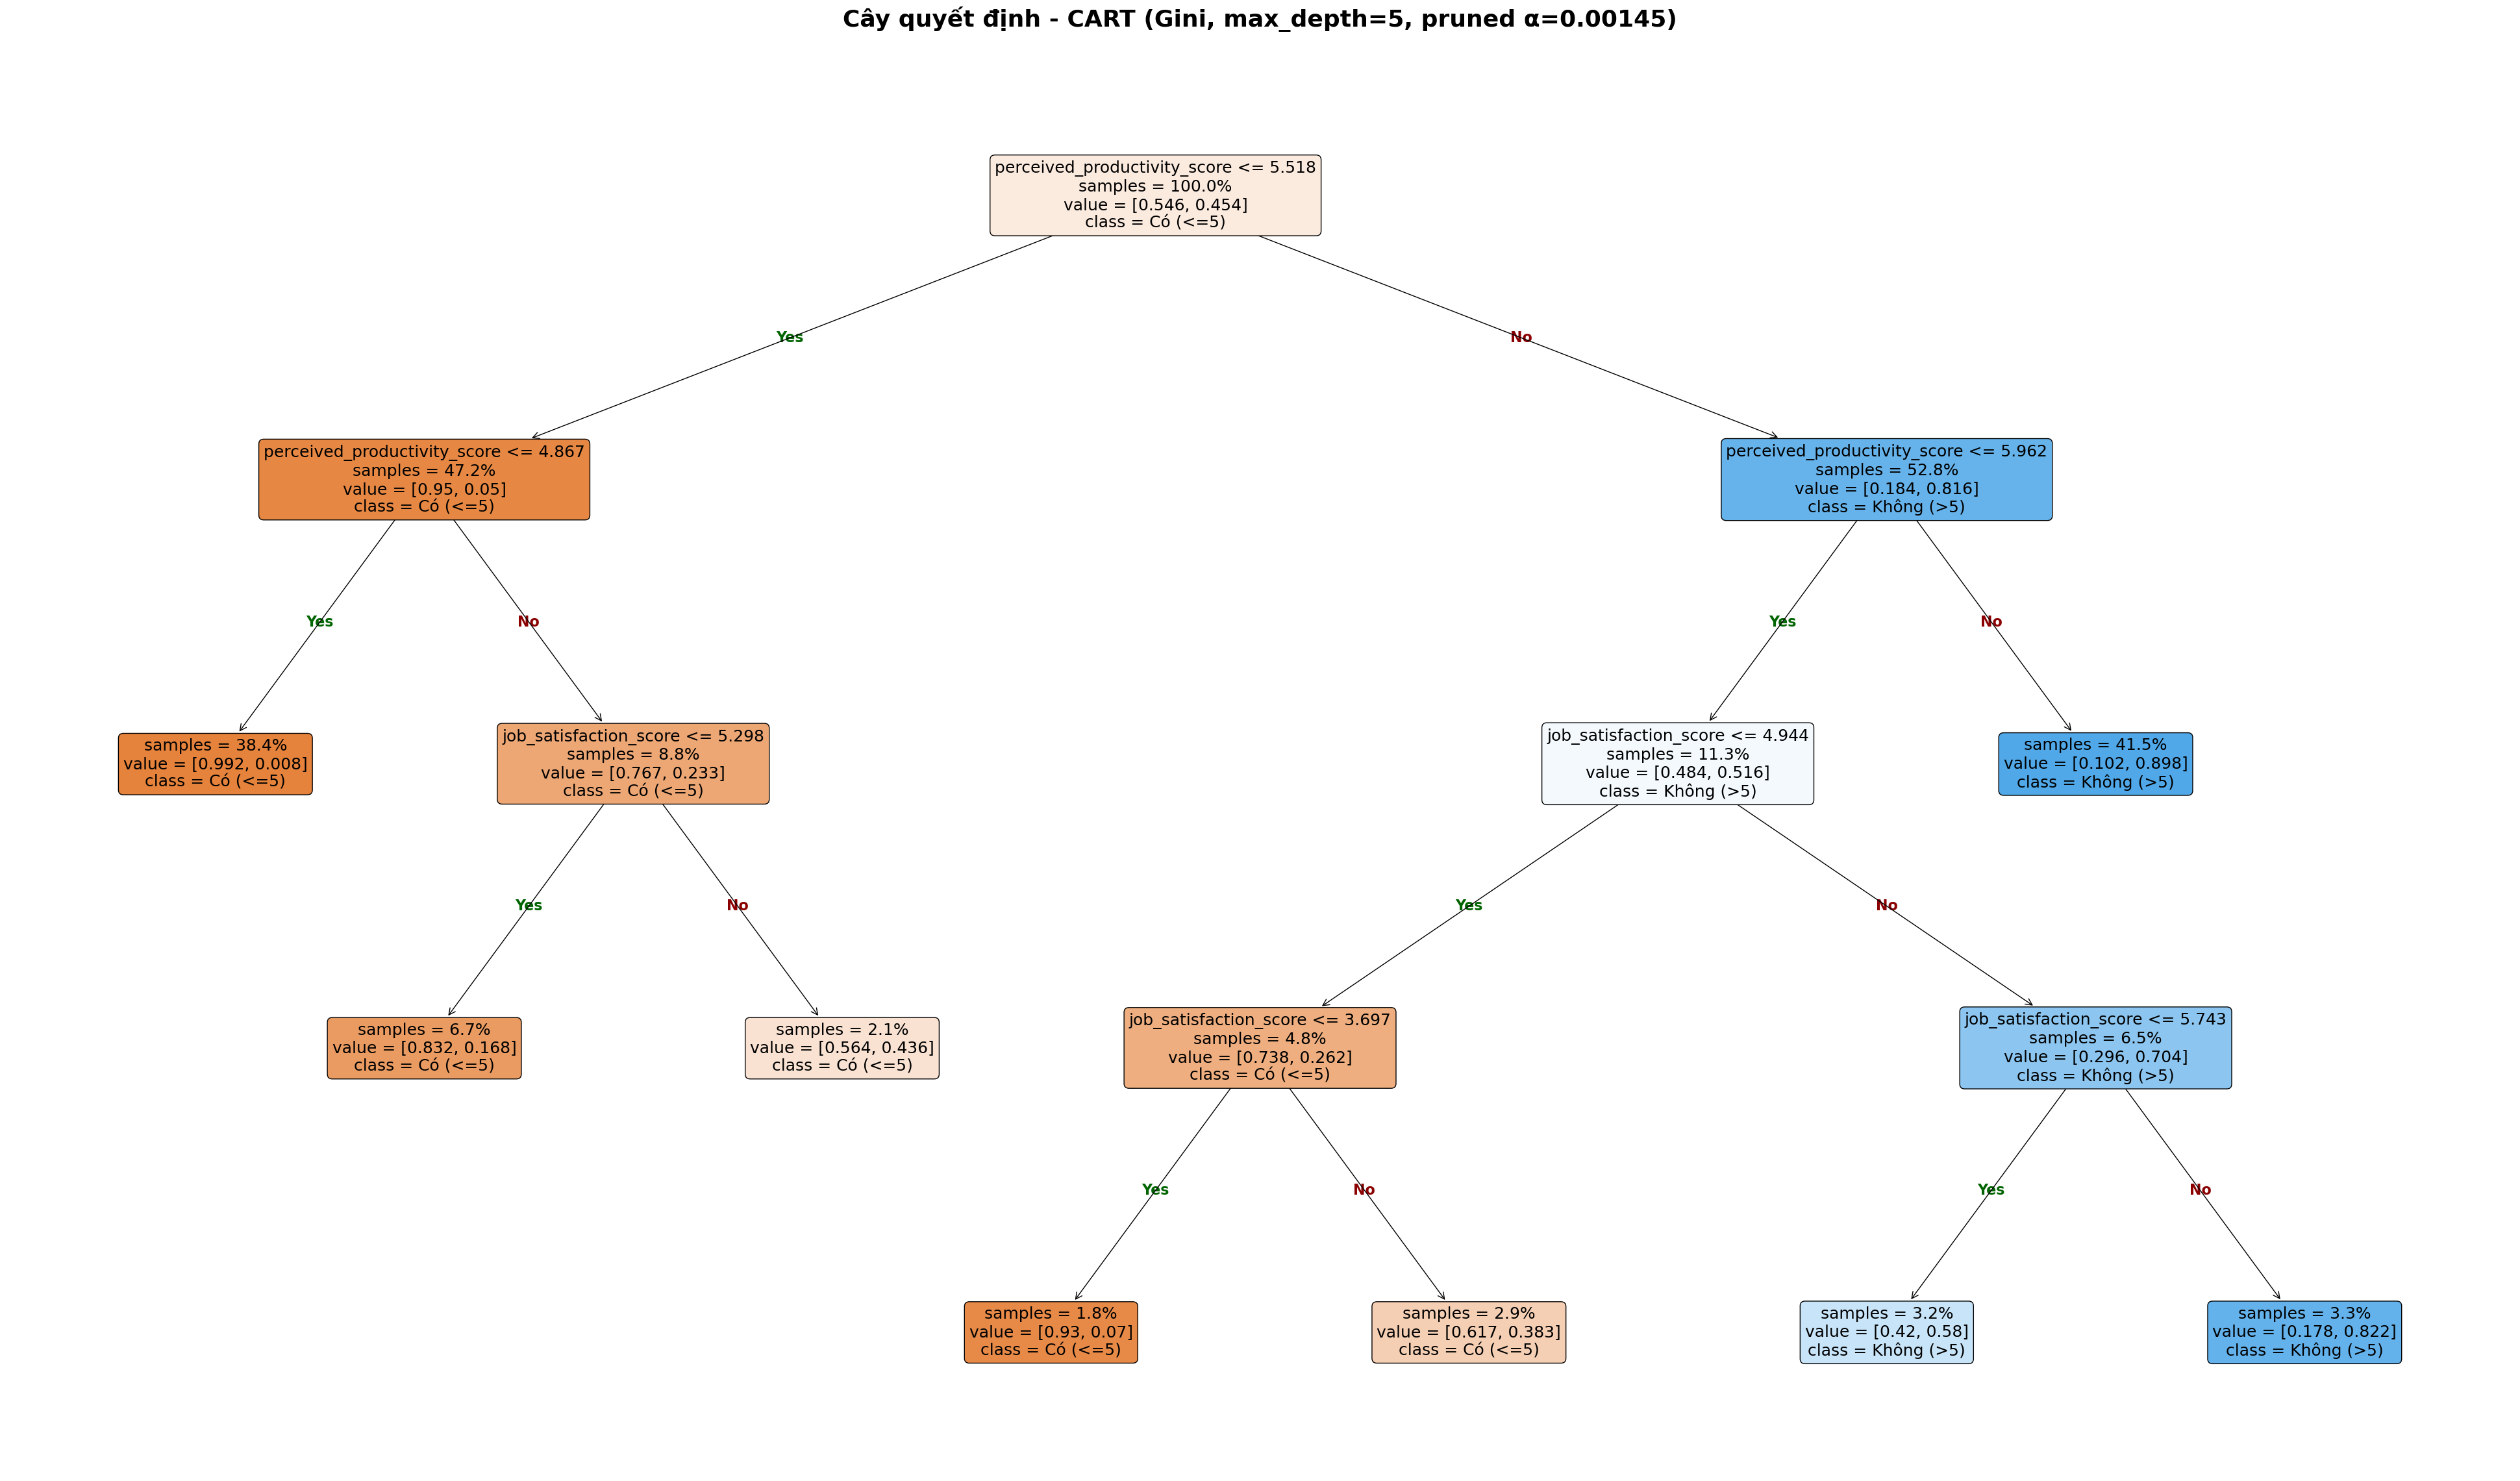

Đã lưu: CART_Gini_Tree_PostPruned.png và CART_Gini_Tree_PostPruned.pdf



In [9]:
# ==========================
# 4.1. Mô hình 2: CART (Gini Index) – CÓ TỰ CHỌN max_depth + POST-PRUNING
# ==========================
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns

# ------------------------------------
# Tìm max_depth tối ưu bằng cross-validation
# ------------------------------------
depths = range(2, 15)
cv_scores = []

for d in depths:
    model = DecisionTreeClassifier(criterion="gini", max_depth=d, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_scores.append(scores.mean())

# Chọn max_depth có accuracy trung bình cao nhất
best_depth_gini = depths[np.argmax(cv_scores)]
best_score_gini = max(cv_scores)

print(f"Max_depth tối ưu cho CART = {best_depth_gini}, CV Accuracy trung bình = {best_score_gini:.4f}")

# ------------------------------------
# Huấn luyện mô hình CART với max_depth tối ưu
# ------------------------------------
dt_gini = DecisionTreeClassifier(criterion="gini", max_depth=best_depth_gini, random_state=42)
dt_gini.fit(X_train, y_train)

# ------------------------------------------------
# 🪚 POST-PRUNING bằng Cost Complexity Pruning
# ------------------------------------------------
print("\n=== Bắt đầu quá trình Post-Pruning cho CART ===")

path = dt_gini.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

models = []
scores = []

for ccp in ccp_alphas:
    model = DecisionTreeClassifier(criterion="gini", max_depth=best_depth_gini, random_state=42, ccp_alpha=ccp)
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_test, y_test, cv=5).mean()
    models.append(model)
    scores.append(score)

# Tìm alpha tối ưu
best_ccp = ccp_alphas[np.argmax(scores)]
best_model = models[np.argmax(scores)]
best_score = max(scores)

print(f"Post-Pruning hoàn tất:")
print(f"   → Best ccp_alpha: {best_ccp:.5f}")
print(f"   → Accuracy sau pruning: {best_score:.4f}")

# ------------------------------------
# Biểu đồ thể hiện sự thay đổi accuracy theo ccp_alpha
# ------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(ccp_alphas, scores, marker='o', color='teal')
plt.title(f"Ảnh hưởng của ccp_alpha đến độ chính xác (Post-Pruning - CART Gini, max_depth={best_depth_gini})")
plt.xlabel("ccp_alpha")
plt.ylabel("CV Accuracy")
plt.grid(True)
plt.show()

# ------------------------------------------------
# Đánh giá mô hình sau khi pruning
# ------------------------------------------------
_ = evaluate_model(best_model, X_train, y_train, X_test, y_test,
                   f"CART (Gini, max_depth={best_depth_gini}, pruned α={best_ccp:.5f})", results)

# ------------------------------------
# Biểu đồ thể hiện sự thay đổi accuracy theo max_depth (ban đầu)
# ------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(depths, cv_scores, marker='o', color='darkorange')
plt.title("Biểu đồ xác định độ sâu tối ưu cho CART (Gini)")
plt.xlabel("max_depth")
plt.ylabel("CV Accuracy (mean)")
plt.grid(True)
plt.show()

# ===============================================================
# TRỰC QUAN HÓA CÂY QUYẾT ĐỊNH CART SAU KHI PRUNING
# ===============================================================
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

def plot_cart_tree(model, X_train, title, filename):
    """Vẽ cây CART phóng to, thêm nhánh Yes/No, lưu PNG và PDF"""
    fig, ax = plt.subplots(figsize=(40, 24))  # 📏 Phóng to toàn bộ cây

    # Vẽ cây với kiểu trình bày đẹp
    nodes = plot_tree(
        model,
        filled=True,
        rounded=True,
        feature_names=X_train.columns,
        class_names=[str(c) for c in model.classes_],
        fontsize=18,
        proportion=True,
        impurity=False,
        ax=ax
    )

    plt.title(title, fontsize=26, fontweight='bold', pad=30)

    # --------------------------------------------------
    # Thêm chữ "Yes" / "No" lên nhánh trái và phải
    # --------------------------------------------------
    tree_ = model.tree_
    for i in range(tree_.node_count):
        if tree_.children_left[i] != -1:  # nếu không phải node lá
            left = tree_.children_left[i]
            right = tree_.children_right[i]

            # Lấy vị trí node cha và node con
            x0, y0 = nodes[i].get_position()
            xL, yL = nodes[left].get_position()
            xR, yR = nodes[right].get_position()

            # Ghi chữ "Yes" và "No"
            plt.text((x0 + xL) / 2, (y0 + yL) / 2, "Yes",
                     fontsize=16, color='darkgreen', ha='center', va='center', fontweight='bold')
            plt.text((x0 + xR) / 2, (y0 + yR) / 2, "No",
                     fontsize=16, color='darkred', ha='center', va='center', fontweight='bold')

    # --------------------------------------------------
    # Lưu cây ra file PNG và PDF
    # --------------------------------------------------
    plt.tight_layout(pad=5.0)
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{filename}.pdf", bbox_inches='tight')
    plt.show()

    print(f"Đã lưu: {filename}.png và {filename}.pdf\n")

# ===============================================================
# GỌI HÀM VẼ CÂY CART SAU KHI POST-PRUNING
# ===============================================================
plot_cart_tree(
    best_model,
    X_train,
    title=f"Cây quyết định - CART (Gini, max_depth={best_depth_gini}, pruned α={best_ccp:.5f})",
    filename="CART_Gini_Tree_PostPruned"
)


Trọng số α được tính tự động = 0.501 (Entropy chiếm 50.1%)
   -> Accuracy trung bình Entropy: 0.8505, Gini: 0.8460

Max_depth tối ưu cho Hybrid Weighted = 5
Cross-validation accuracy trung bình = 0.9016


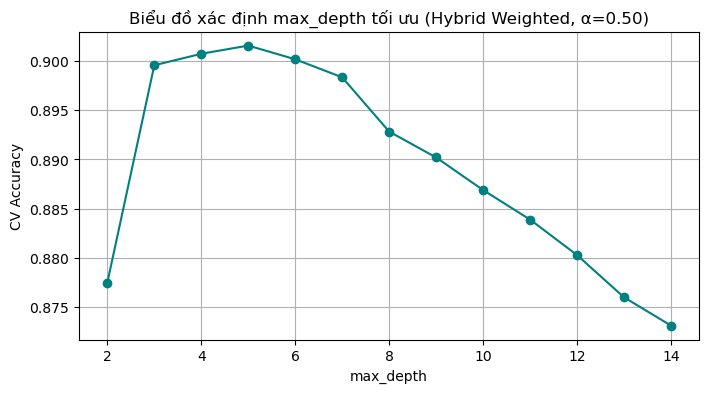


=== Hybrid Weighted (α=0.50, max_depth=5) ===
Accuracy: 0.8975 | F1: 0.8977 | Recall: 0.8975 | Precision: 0.8992
Confusion matrix:
 [[2887  388]
 [ 227 2498]]


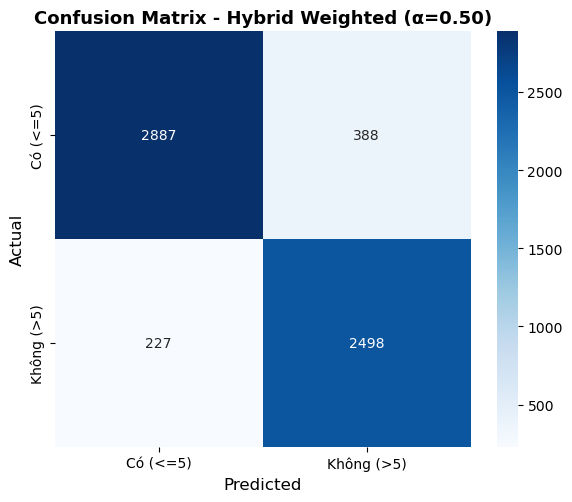

In [10]:
# ===============================
# 5.  Mô hình Hybrid Decision Tree (Weighted Criterion)
#     - Bản 2: Weighted Criterion α * Entropy + (1-α) * Gini
#     - Tự động tính α dựa vào độ chính xác và dò max_depth
# ===============================

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# MÃ HÓA NHÃN
# ------------------------------
label_encoder_y = LabelEncoder()
y_train = label_encoder_y.fit_transform(y_train)
y_test = label_encoder_y.transform(y_test)

# ------------------------------
# LỚP HYBRID WEIGHTED
# ------------------------------
class HybridWeightedDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=0.5, max_depth=8):
        self.alpha = alpha
        self.max_depth = max_depth
        self.model_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=42)
        self.model_gini = DecisionTreeClassifier(criterion="gini", max_depth=max_depth, random_state=42)

    def fit(self, X, y):
        self.model_entropy.fit(X, y)
        self.model_gini.fit(X, y)
        return self

    def predict(self, X):
        pred_entropy = self.model_entropy.predict_proba(X)
        pred_gini = self.model_gini.predict_proba(X)

        n_classes = max(pred_entropy.shape[1], pred_gini.shape[1])
        def pad_probs(p, n):
            if p.shape[1] < n:
                p = np.hstack([p, np.zeros((p.shape[0], n - p.shape[1]))])
            return p

        pred_entropy = pad_probs(pred_entropy, n_classes)
        pred_gini = pad_probs(pred_gini, n_classes)

        weighted_pred = self.alpha * pred_entropy + (1 - self.alpha) * pred_gini
        y_pred = np.argmax(weighted_pred, axis=1)
        return y_pred


# ------------------------------
# TỰ ĐỘNG TÍNH α DỰA TRÊN ACCURACY
# ------------------------------
temp_entropy = DecisionTreeClassifier(criterion="entropy", random_state=42)
temp_gini = DecisionTreeClassifier(criterion="gini", random_state=42)

acc_entropy = cross_val_score(temp_entropy, X_train, y_train, cv=5).mean()
acc_gini = cross_val_score(temp_gini, X_train, y_train, cv=5).mean()

# alpha tỷ lệ thuận với hiệu suất của cây entropy
alpha_value = acc_entropy / (acc_entropy + acc_gini)
print(f"Trọng số α được tính tự động = {alpha_value:.3f} (Entropy chiếm {alpha_value*100:.1f}%)")
print(f"   -> Accuracy trung bình Entropy: {acc_entropy:.4f}, Gini: {acc_gini:.4f}")

# ------------------------------
# DÒ MAX_DEPTH TỐI ƯU
# ------------------------------
depths = range(2, 15)
cv_scores = []

for d in depths:
    model = HybridWeightedDecisionTree(alpha=alpha_value, max_depth=d)
    model.fit(X_train, y_train)
    score_entropy = cross_val_score(model.model_entropy, X_train, y_train, cv=5).mean()
    score_gini = cross_val_score(model.model_gini, X_train, y_train, cv=5).mean()
    avg_score = alpha_value * score_entropy + (1 - alpha_value) * score_gini
    cv_scores.append(avg_score)

best_depth_hybrid = depths[np.argmax(cv_scores)]
best_cv_score = max(cv_scores)
print(f"\nMax_depth tối ưu cho Hybrid Weighted = {best_depth_hybrid}")
print(f"Cross-validation accuracy trung bình = {best_cv_score:.4f}")

# ------------------------------
# BIỂU ĐỒ MINH HỌA
# ------------------------------
plt.figure(figsize=(8, 4))
plt.plot(depths, cv_scores, marker='o', color='teal')
plt.title(f"Biểu đồ xác định max_depth tối ưu (Hybrid Weighted, α={alpha_value:.2f})")
plt.xlabel("max_depth")
plt.ylabel("CV Accuracy")
plt.grid(True)
plt.show()

# ------------------------------
# HUẤN LUYỆN CUỐI CÙNG VÀ ĐÁNH GIÁ
# ------------------------------
import seaborn as sns

hybrid2 = HybridWeightedDecisionTree(alpha=alpha_value, max_depth=best_depth_hybrid)
hybrid2.fit(X_train, y_train)
y_pred_hybrid2 = hybrid2.predict(X_test)

# Chuyển nhãn mã hóa về dạng gốc
y_pred_hybrid2_labels = label_encoder_y.inverse_transform(y_pred_hybrid2)
y_test_labels = label_encoder_y.inverse_transform(y_test)

# Đánh giá chỉ số
acc = accuracy_score(y_test_labels, y_pred_hybrid2_labels)
f1 = f1_score(y_test_labels, y_pred_hybrid2_labels, average='weighted')
rec = recall_score(y_test_labels, y_pred_hybrid2_labels, average='weighted')
pre = precision_score(y_test_labels, y_pred_hybrid2_labels, average='weighted')
cm = confusion_matrix(y_test_labels, y_pred_hybrid2_labels)

print(f"\n=== Hybrid Weighted (α={alpha_value:.2f}, max_depth={best_depth_hybrid}) ===")
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Recall: {rec:.4f} | Precision: {pre:.4f}")
print("Confusion matrix:\n", cm)

# ------------------------------------
# Vẽ CONFUSION MATRIX trực quan
# ------------------------------------
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    square=True,
    xticklabels=np.unique(y_test_labels),
    yticklabels=np.unique(y_test_labels)
)
plt.title(f"Confusion Matrix - Hybrid Weighted (α={alpha_value:.2f})", fontsize=13, fontweight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

# ------------------------------------
# Lưu kết quả vào DataFrame
# ------------------------------------
results.append({
    'model': f'Hybrid Weighted (auto α={alpha_value:.2f})',
    'accuracy': acc,
    'f1': f1,
    'recall': rec,
    'precision': pre,
    'depth': best_depth_hybrid,
    'nodes': np.nan
})



Trọng số α được tính tự động = 0.501 (Entropy chiếm 50.1%)
   -> Accuracy trung bình Entropy: 0.8505, Gini: 0.8460

Max_depth tối ưu cho Hybrid Weighted = 5
Cross-validation accuracy trung bình = 0.9016


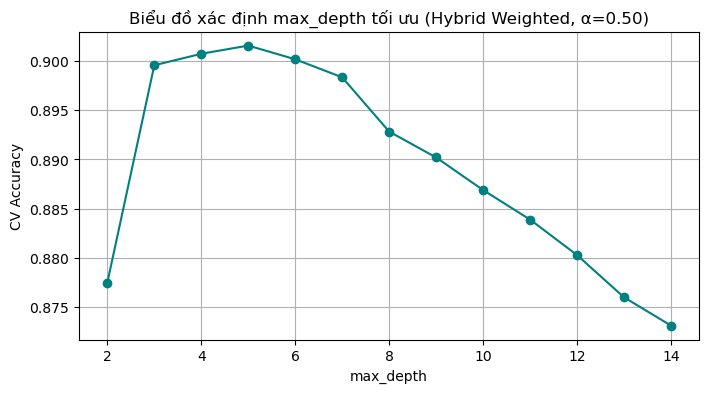

Post-Pruning hoàn tất:
   - Entropy best_ccp_alpha = 0.00057
   - Gini best_ccp_alpha    = 0.00036

=== Hybrid Weighted (α=0.50, max_depth=5, Post-Pruned) ===
Accuracy: 0.8977 | F1: 0.8979 | Recall: 0.8977 | Precision: 0.8997
Confusion matrix:
 [[2878  397]
 [ 217 2508]]


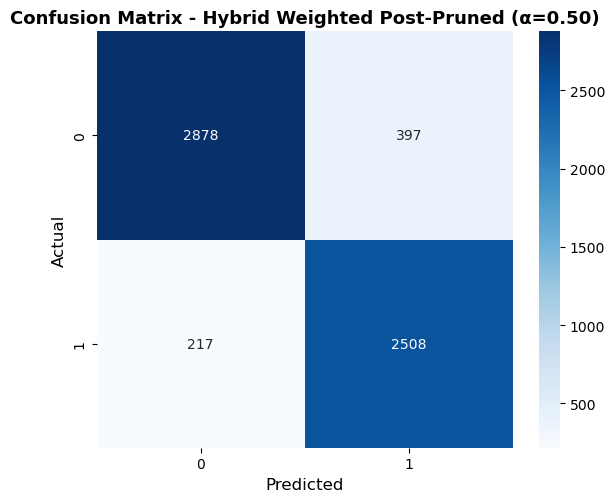

In [11]:
# ===============================
# 5.1 . Mô hình Hybrid Decision Tree (Weighted Criterion)
#     - Bản 2: Weighted Criterion α * Entropy + (1-α) * Gini
#     - Tự động tính α dựa vào độ chính xác và dò max_depth
#     - Bổ sung Post-Pruning (Cost Complexity Pruning)
# ===============================

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# MÃ HÓA NHÃN
# ------------------------------
label_encoder_y = LabelEncoder()
y_train = label_encoder_y.fit_transform(y_train)
y_test = label_encoder_y.transform(y_test)

# ------------------------------
# LỚP HYBRID WEIGHTED
# ------------------------------
class HybridWeightedDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=0.5, max_depth=8, prune=False):
        self.alpha = alpha
        self.max_depth = max_depth
        self.prune = prune
        self.model_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=42)
        self.model_gini = DecisionTreeClassifier(criterion="gini", max_depth=max_depth, random_state=42)

    def fit(self, X, y):
        # Huấn luyện ban đầu
        self.model_entropy.fit(X, y)
        self.model_gini.fit(X, y)

        # ============================
        # 🪚 POST-PRUNING (nếu bật)
        # ============================
        if self.prune:
            # Prune cây Entropy
            path_e = self.model_entropy.cost_complexity_pruning_path(X, y)
            ccp_alphas_e = path_e.ccp_alphas
            models_e, scores_e = [], []

            for ccp in ccp_alphas_e:
                model_e = DecisionTreeClassifier(criterion="entropy", random_state=42, ccp_alpha=ccp)
                model_e.fit(X, y)
                score_e = cross_val_score(model_e, X, y, cv=5).mean()
                models_e.append(model_e)
                scores_e.append(score_e)

            best_ccp_e = ccp_alphas_e[np.argmax(scores_e)]
            self.model_entropy = models_e[np.argmax(scores_e)]

            # Prune cây Gini
            path_g = self.model_gini.cost_complexity_pruning_path(X, y)
            ccp_alphas_g = path_g.ccp_alphas
            models_g, scores_g = [], []

            for ccp in ccp_alphas_g:
                model_g = DecisionTreeClassifier(criterion="gini", random_state=42, ccp_alpha=ccp)
                model_g.fit(X, y)
                score_g = cross_val_score(model_g, X, y, cv=5).mean()
                models_g.append(model_g)
                scores_g.append(score_g)

            best_ccp_g = ccp_alphas_g[np.argmax(scores_g)]
            self.model_gini = models_g[np.argmax(scores_g)]

            print(f"Post-Pruning hoàn tất:")
            print(f"   - Entropy best_ccp_alpha = {best_ccp_e:.5f}")
            print(f"   - Gini best_ccp_alpha    = {best_ccp_g:.5f}")

        return self

    def predict(self, X):
        pred_entropy = self.model_entropy.predict_proba(X)
        pred_gini = self.model_gini.predict_proba(X)

        # Chuẩn hóa chiều xác suất
        n_classes = max(pred_entropy.shape[1], pred_gini.shape[1])
        def pad_probs(p, n):
            if p.shape[1] < n:
                p = np.hstack([p, np.zeros((p.shape[0], n - p.shape[1]))])
            return p

        pred_entropy = pad_probs(pred_entropy, n_classes)
        pred_gini = pad_probs(pred_gini, n_classes)

        weighted_pred = self.alpha * pred_entropy + (1 - self.alpha) * pred_gini
        y_pred = np.argmax(weighted_pred, axis=1)
        return y_pred


# ------------------------------
# TỰ ĐỘNG TÍNH α DỰA TRÊN ACCURACY
# ------------------------------
temp_entropy = DecisionTreeClassifier(criterion="entropy", random_state=42)
temp_gini = DecisionTreeClassifier(criterion="gini", random_state=42)

acc_entropy = cross_val_score(temp_entropy, X_train, y_train, cv=5).mean()
acc_gini = cross_val_score(temp_gini, X_train, y_train, cv=5).mean()

alpha_value = acc_entropy / (acc_entropy + acc_gini)
print(f"Trọng số α được tính tự động = {alpha_value:.3f} (Entropy chiếm {alpha_value*100:.1f}%)")
print(f"   -> Accuracy trung bình Entropy: {acc_entropy:.4f}, Gini: {acc_gini:.4f}")

# ------------------------------
# DÒ MAX_DEPTH TỐI ƯU
# ------------------------------
depths = range(2, 15)
cv_scores = []

for d in depths:
    model = HybridWeightedDecisionTree(alpha=alpha_value, max_depth=d)
    model.fit(X_train, y_train)
    score_entropy = cross_val_score(model.model_entropy, X_train, y_train, cv=5).mean()
    score_gini = cross_val_score(model.model_gini, X_train, y_train, cv=5).mean()
    avg_score = alpha_value * score_entropy + (1 - alpha_value) * score_gini
    cv_scores.append(avg_score)

best_depth_hybrid = depths[np.argmax(cv_scores)]
best_cv_score = max(cv_scores)
print(f"\nMax_depth tối ưu cho Hybrid Weighted = {best_depth_hybrid}")
print(f"Cross-validation accuracy trung bình = {best_cv_score:.4f}")

# ------------------------------
# BIỂU ĐỒ MINH HỌA MAX_DEPTH
# ------------------------------
plt.figure(figsize=(8, 4))
plt.plot(depths, cv_scores, marker='o', color='teal')
plt.title(f"Biểu đồ xác định max_depth tối ưu (Hybrid Weighted, α={alpha_value:.2f})")
plt.xlabel("max_depth")
plt.ylabel("CV Accuracy")
plt.grid(True)
plt.show()

# ============================================================
# HUẤN LUYỆN CUỐI CÙNG (CÓ POST-PRUNING)
# ============================================================
hybrid2 = HybridWeightedDecisionTree(alpha=alpha_value, max_depth=best_depth_hybrid, prune=True)
hybrid2.fit(X_train, y_train)
y_pred_hybrid2 = hybrid2.predict(X_test)

# Chuyển nhãn về dạng gốc
y_pred_hybrid2_labels = label_encoder_y.inverse_transform(y_pred_hybrid2)
y_test_labels = label_encoder_y.inverse_transform(y_test)

# Đánh giá mô hình
acc = accuracy_score(y_test_labels, y_pred_hybrid2_labels)
f1 = f1_score(y_test_labels, y_pred_hybrid2_labels, average='weighted')
rec = recall_score(y_test_labels, y_pred_hybrid2_labels, average='weighted')
pre = precision_score(y_test_labels, y_pred_hybrid2_labels, average='weighted')
cm = confusion_matrix(y_test_labels, y_pred_hybrid2_labels)

print(f"\n=== Hybrid Weighted (α={alpha_value:.2f}, max_depth={best_depth_hybrid}, Post-Pruned) ===")
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Recall: {rec:.4f} | Precision: {pre:.4f}")
print("Confusion matrix:\n", cm)

# ------------------------------------
# Vẽ CONFUSION MATRIX trực quan
# ------------------------------------
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    square=True,
    xticklabels=np.unique(y_test_labels),
    yticklabels=np.unique(y_test_labels)
)
plt.title(f"Confusion Matrix - Hybrid Weighted Post-Pruned (α={alpha_value:.2f})", fontsize=13, fontweight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

# ------------------------------------
# Lưu kết quả vào DataFrame
# ------------------------------------
results.append({
    'model': f'Hybrid Weighted Post-Pruned (auto α={alpha_value:.2f})',
    'accuracy': acc,
    'f1': f1,
    'recall': rec,
    'precision': pre,
    'depth': best_depth_hybrid,
    'nodes': np.nan
})


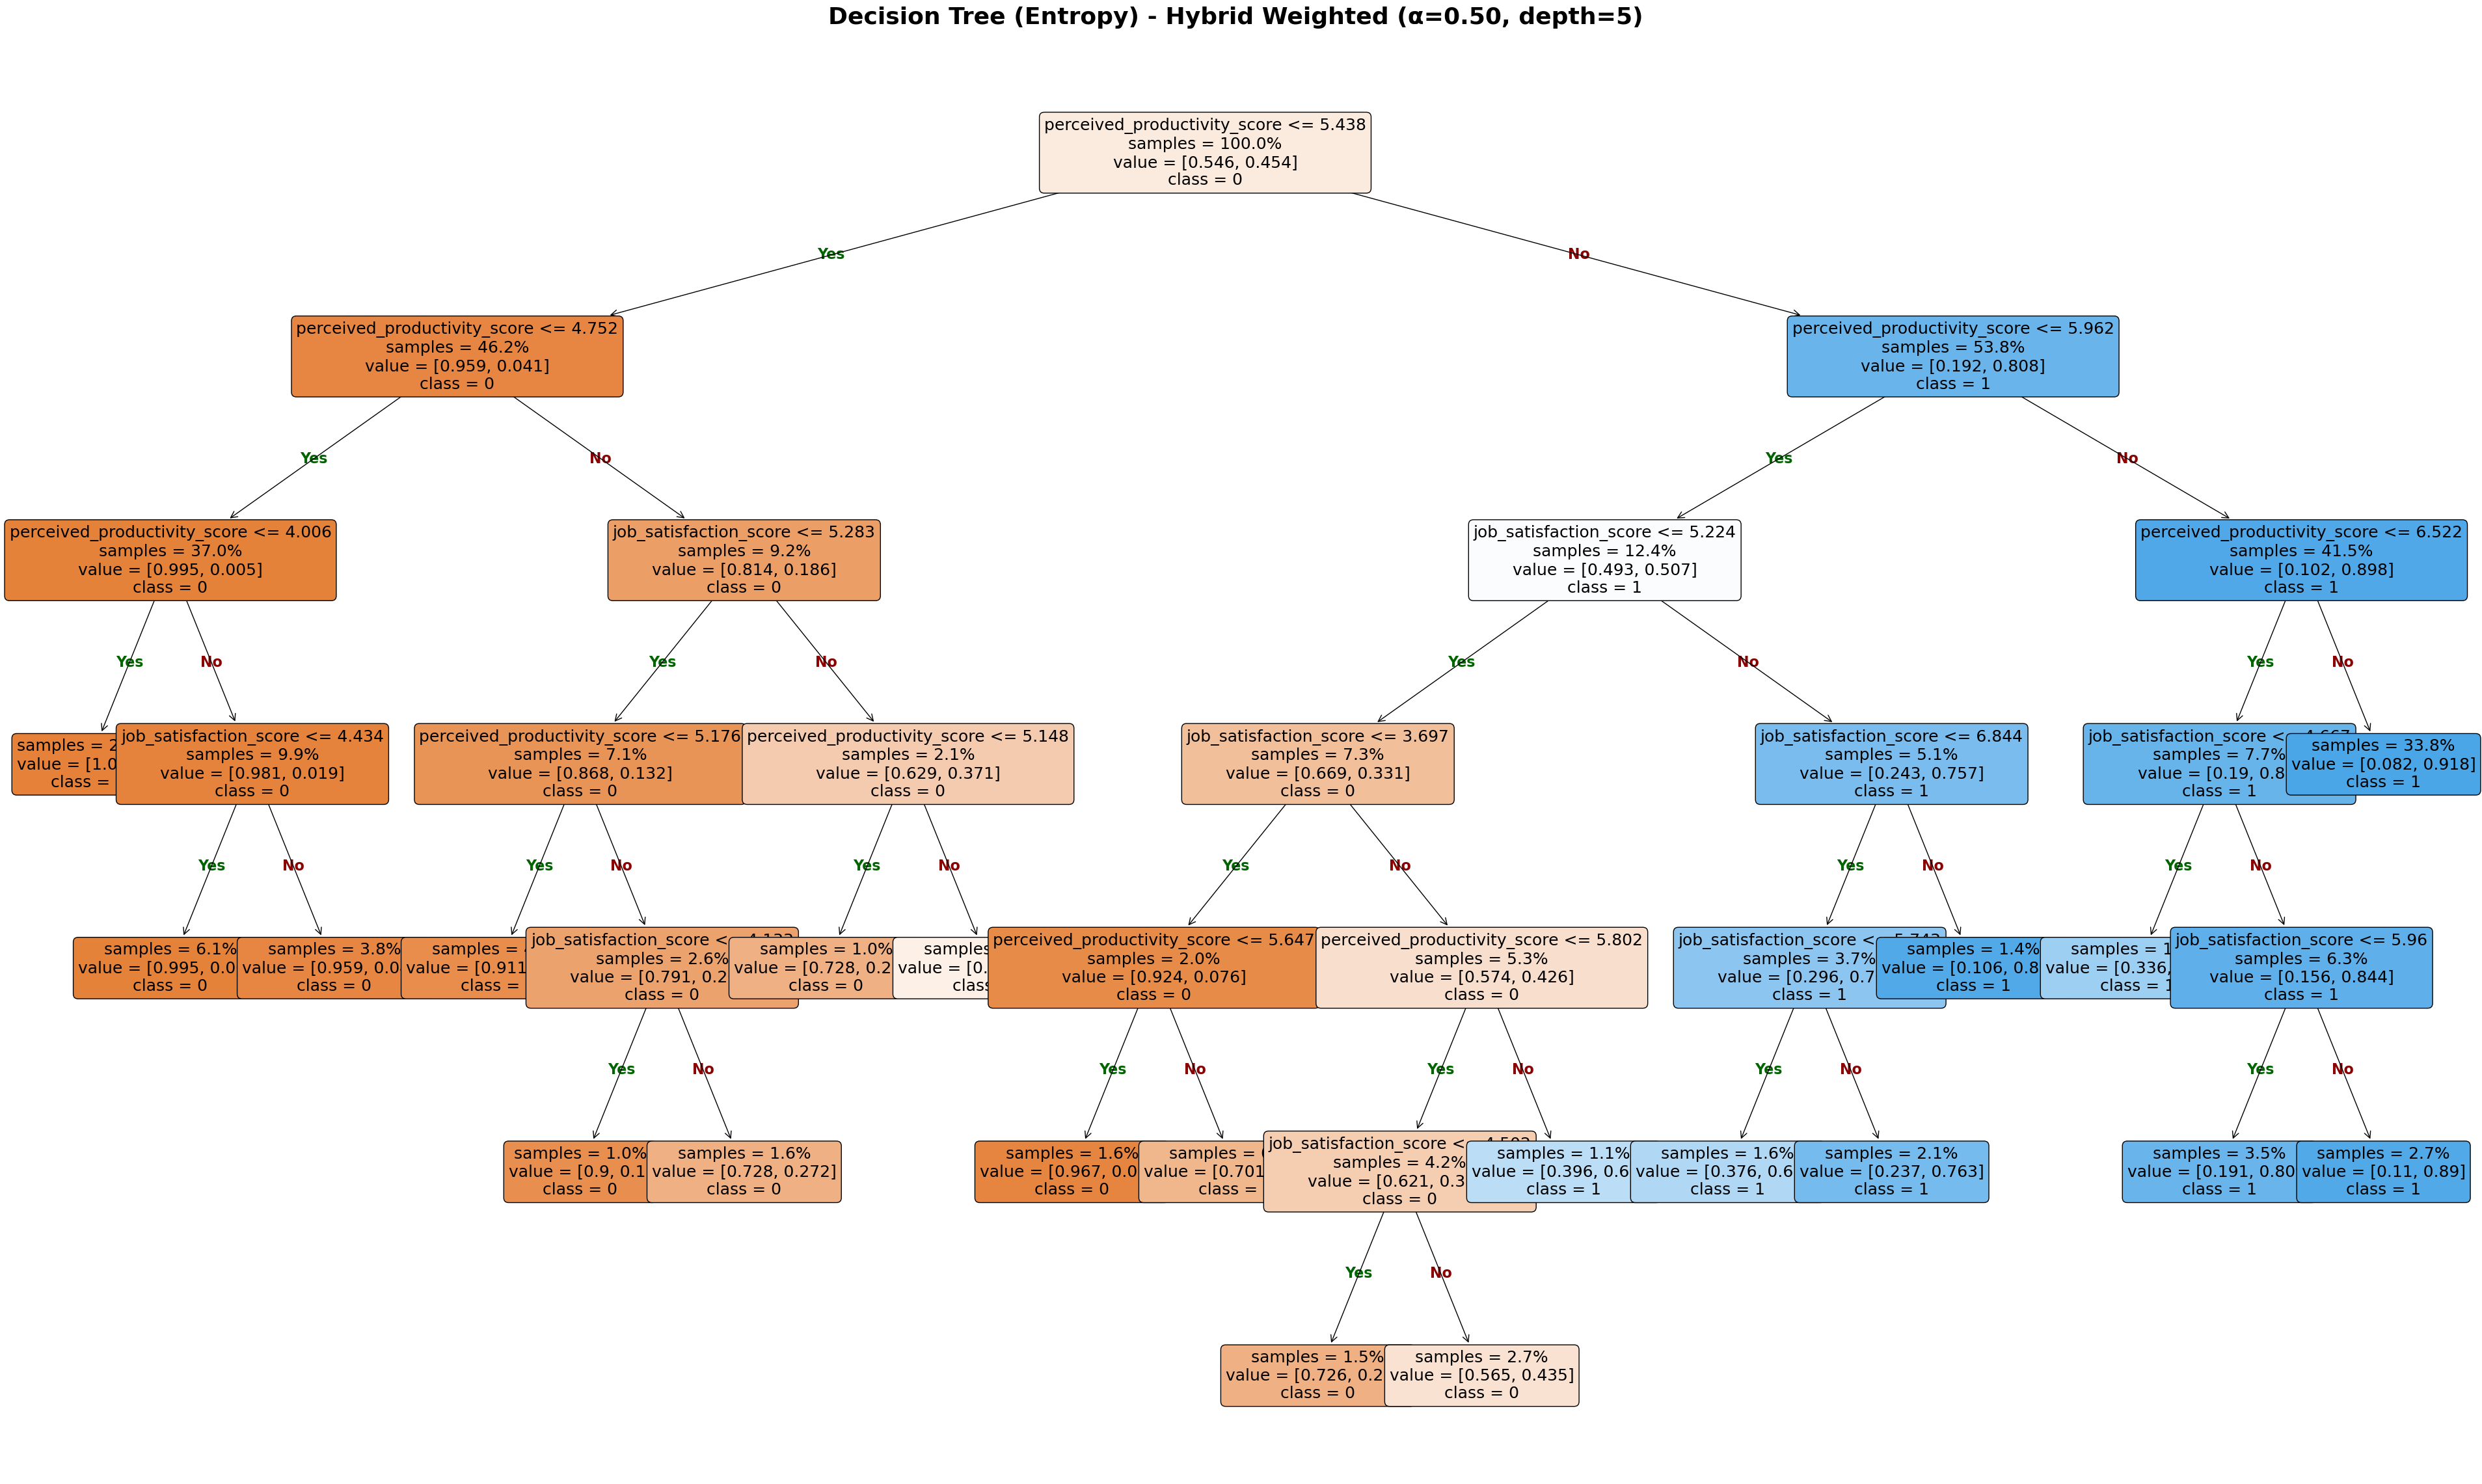

Đã lưu: Hybrid_Entropy_Tree.png và Hybrid_Entropy_Tree.pdf



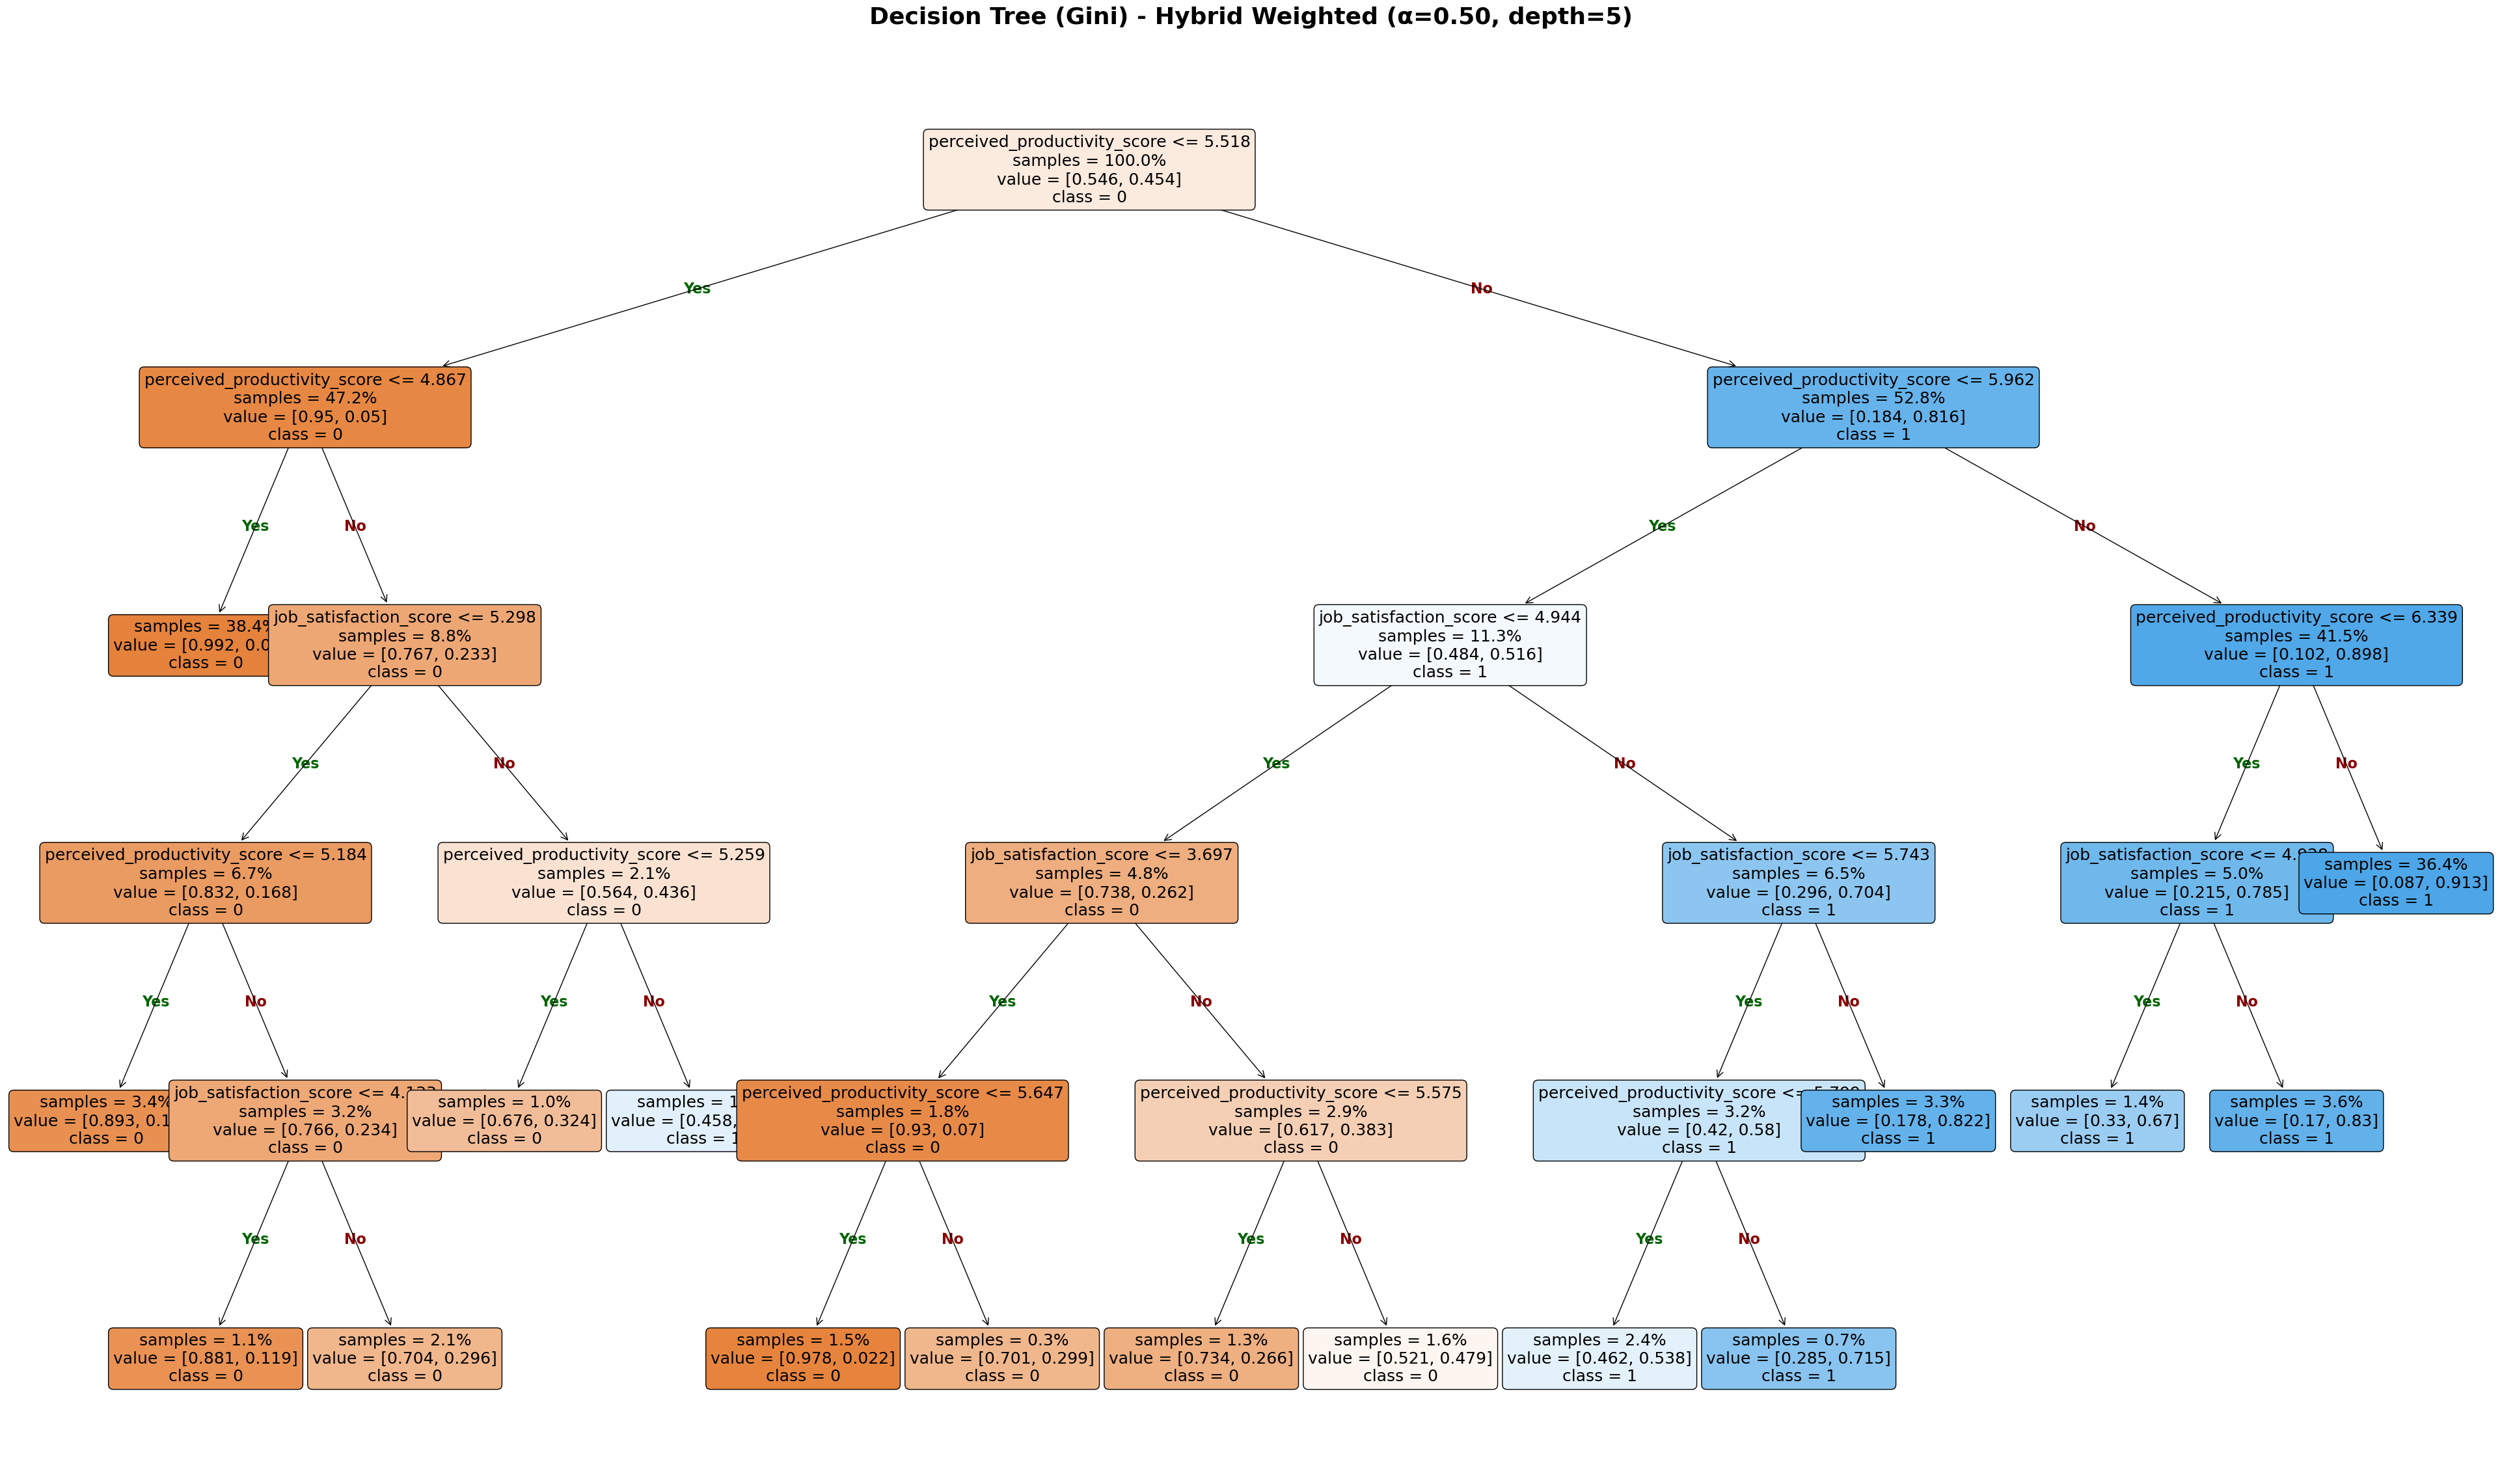

Đã lưu: Hybrid_Gini_Tree.png và Hybrid_Gini_Tree.pdf



In [16]:
# ===============================================================
# VẼ CÂY QUYẾT ĐỊNH HYBRID WEIGHTED (Entropy + Gini)
# ===============================================================
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

def plot_decision_tree(model, X_train, title, filename):
    """Vẽ cây quyết định phóng to + nhánh Yes/No + lưu PNG/PDF"""
    fig, ax = plt.subplots(figsize=(40, 24))  # phóng to toàn bộ cây

    # Vẽ cây
    nodes = plot_tree(
        model,
        filled=True,
        rounded=True,
        feature_names=X_train.columns,
        class_names=[str(c) for c in model.classes_],
        fontsize=18,
        proportion=True,
        impurity=False,
        ax=ax
    )

    plt.title(title, fontsize=26, fontweight='bold', pad=30)

    # --------------------------------
    # Thêm chữ "Yes" / "No" trên các nhánh
    # --------------------------------
    tree_ = model.tree_
    for i in range(tree_.node_count):
        if tree_.children_left[i] != -1:  # chỉ xét các node không phải lá
            left = tree_.children_left[i]
            right = tree_.children_right[i]

            # Lấy vị trí node cha và node con (tọa độ ảo trong matplotlib)
            x0, y0 = nodes[i].get_position()
            xL, yL = nodes[left].get_position()
            xR, yR = nodes[right].get_position()

            plt.text((x0 + xL) / 2, (y0 + yL) / 2, "Yes",
                     fontsize=16, color='darkgreen', ha='center', va='center', fontweight='bold')
            plt.text((x0 + xR) / 2, (y0 + yR) / 2, "No",
                     fontsize=16, color='darkred', ha='center', va='center', fontweight='bold')

    plt.tight_layout(pad=5.0)
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{filename}.pdf", bbox_inches='tight')
    plt.show()
    print(f"Đã lưu: {filename}.png và {filename}.pdf\n")


# ===============================================================
# GỌI HÀM VẼ CHO 2 CÂY TRONG HYBRID
# ===============================================================
plot_decision_tree(
    hybrid2.model_entropy,
    X_train,
    title=f"Decision Tree (Entropy) - Hybrid Weighted (α={alpha_value:.2f}, depth={best_depth_hybrid})",
    filename="Hybrid_Entropy_Tree"
)

plot_decision_tree(
    hybrid2.model_gini,
    X_train,
    title=f"Decision Tree (Gini) - Hybrid Weighted (α={alpha_value:.2f}, depth={best_depth_hybrid})",
    filename="Hybrid_Gini_Tree"
)




Top features (ID3):
 perceived_productivity_score    0.943251
job_satisfaction_score          0.055244
age                             0.000606
coffee_consumption_per_day      0.000485
screen_time_before_sleep        0.000414
daily_social_media_time         0.000000
social_platform_preference      0.000000
number_of_notifications         0.000000
work_hours_per_day              0.000000
job_type                        0.000000
dtype: float64

Top features (CART):
 perceived_productivity_score    0.943919
job_satisfaction_score          0.055807
age                             0.000274
daily_social_media_time         0.000000
social_platform_preference      0.000000
number_of_notifications         0.000000
work_hours_per_day              0.000000
job_type                        0.000000
stress_level                    0.000000
gender                          0.000000
dtype: float64

Correlation between daily_social_media_time and actual_productivity_score: nan


c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


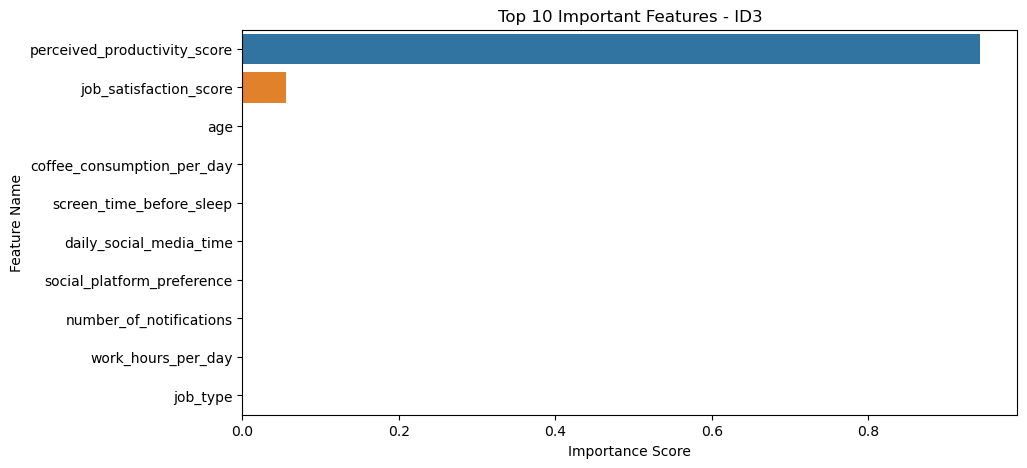

In [13]:
# ===============================
# 6 . Phân tích Feature Importance & Correlation
# ===============================
importance_entropy = pd.Series(dt_entropy.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importance_gini = pd.Series(dt_gini.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("\nTop features (ID3):\n", importance_entropy.head(10))
print("\nTop features (CART):\n", importance_gini.head(10))

# Chuyển kiểu dữ liệu sang số (nếu cần)
x_time = pd.to_numeric(X['daily_social_media_time'], errors='coerce')
y_num = pd.to_numeric(y, errors='coerce')

# Loại bỏ các giá trị NaN để tránh lỗi
mask = ~np.isnan(x_time) & ~np.isnan(y_num)
corr = np.corrcoef(x_time[mask], y_num[mask])[0, 1]

print(f"\nCorrelation between daily_social_media_time and actual_productivity_score: {corr:.4f}")

# Biểu đồ tầm quan trọng của đặc trưng (ID3)
plt.figure(figsize=(10, 5))
sns.barplot(x=importance_entropy.head(10).values, y=importance_entropy.head(10).index)
plt.title("Top 10 Important Features - ID3")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()


In [14]:
# ==========================
# 7 . So sánh toàn bộ mô hình
# ==========================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='accuracy', ascending=False)
print("\nBẢNG SO SÁNH HIỆU SUẤT MÔ HÌNH:")
display(results_df)



BẢNG SO SÁNH HIỆU SUẤT MÔ HÌNH:


model  accuracy        f1    recall  \
5   Hybrid Weighted Post-Pruned (auto α=0.50)  0.897667  0.897857  0.897667   
4               Hybrid Weighted (auto α=0.50)  0.897500  0.897679  0.897500   
0                  ID3 (Entropy, max_depth=5)  0.897333  0.897498  0.897333   
1         ID3 Post-Pruned (ccp_alpha=0.00050)  0.896833  0.896996  0.896833   
2                    CART (Gini, max_depth=5)  0.895167  0.895369  0.895167   
3  CART (Gini, max_depth=5, pruned α=0.00145)  0.893833  0.894016  0.893833   

   precision  depth  nodes  
5   0.899663      5    NaN  
4   0.899151      5    NaN  
0   0.898640      5   29.0  
1   0.898095      6   20.0  
2   0.897463      5   31.0  
3   0.895424      4    8.0